# Nanofiber diamter vs standing wave pitch

Here we follow the derivation in ref.[1].

### Relation between the propagation constant and diameter
In an optical nanofiber, the propagating light exists both in the silica fiber and the surrounding air. Therefore the effective refractive index $n_{eff}$ has a value between those of air and the fiber $n_{air}<n_{eff}<n_{fiber}$ depending on the diameter. The propagation constant of light in the nanofiber is then defined as
$$ \beta = n_{eff} k_0 = \frac{2\pi n_{eff}}{\lambda_0}, $$
with the wave number $k_0=2\pi/\lambda_0$ for the wavelength of the light in vacuum $\lambda_0$.

The fiber diameter $D$ has a quantitative relationship with $\beta$ through the optical fiber eigenvalue equation [2}
$$
m^2 \biggl(\frac{1}{u^2} + \frac{1}{w^2}\biggr)\biggl(\frac{1}{u^2} + \frac{n^2_{air}}{n^2_{fiber}} \cdot \frac{1}{w^2}\biggr)
= \biggl(\frac{1}{u} \cdot \frac{J'_{m}(u)}{J_{m}(u)} + \frac{1}{w} \cdot \frac{K'_{m}(w)}{K_{m}(w)}\biggr)\biggl(\frac{1}{u} \cdot \frac{J'_{m}(u)}{J_{m}(u)} + \frac{n^2_{air}}{n^2_{fiber}} \cdot \frac{1}{w} \cdot \frac{K'_{m}(w)}{K_{m}(w)}\biggr),
$$
$$
\textrm{with}~~~u = \frac{D}{2}\sqrt{k^2_{0}n^2_{fiber} - \beta^2},~~w = \frac{D}{2}\sqrt{\beta^2 - k^2_{0}n^2_{air}}.
$$
Here $J_{m}$ and $K_{m}$ are the Bessel function of the first kind and the modified Bessel function of the second kind with the order $m$, respectively. For single mode fibers supporting only $HE_{11}$ mode\), $m=1$. Once we obtain $\beta$, we can deduce $D$ by solving the equation.

### Experimentally measure the propagation constant
For a linearly polarized input light, the evanescent field $\textbf{E}=(E_x,E_y,E_z)$ of the fundamental mode in a fiber can be expressed as [3]
$$ 
E_{x}(r,\phi,z,t) = A(r,\phi) e^{i(\omega t-\beta z)}, \\
E_{y}(r,\phi,z,t) = B(r,\phi) e^{i(\omega t-\beta z)}, \\
E_{x}(r,\phi,z,t) = iC(r,\phi) e^{i(\omega t-\beta z)}. 
$$

**References**\
[1] Y. Liu *et al.*, [Optics Letters **49**, 2649 (2024)](https://doi.org/10.1364/OL.521545).\
[2] L. Tong *et al.*, [Optics Express **12**, 1025 (2004)](https://opg.optica.org/oe/fulltext.cfm?uri=oe-12-6-1025&id=79250).\
[3] A. Goban, PhD thesis (2015).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.special import jv, kv, jvp, kvp
from scipy.optimize import root_scalar
from scipy.constants import c

nm = 1e-9
um = 1e-6
mm = 1e-3

plt.rc('text', usetex = True)
plt.rc('font', size = 8)
plt.rcParams['xtick.major.size'] = 2.
plt.rcParams['ytick.major.size'] = 2.
plt.rcParams['xtick.major.pad'] = 2.
plt.rcParams['ytick.major.pad'] = 2.
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['figure.dpi'] = 500

### Refractive index
The Sellmeier formula gives the wavelength dependence of the refractive index of a transparent material in the form
$$ n^2(\lambda) = 1 + \sum_i \frac{A_i \lambda^2}{\lambda^2 - B_i}, $$
with the coefficients $A_i$ and $B_i$. It is common to use three terms and for fused silica the coefficients are given for example [here](https://www.rp-photonics.com/sellmeier_formula.html).

In [2]:
n_air = 1.0
def n_silica(wavelength):
    """ Refractive index of silica using the Sellmeier formula """
    wavelength /= um # Wavelength in unit of um
    return np.sqrt(1 + ((0.6961663 * wavelength**2)/((wavelength**2)-(0.0684043)**2)) \
                   + ((0.4079426 * wavelength**2) / ((wavelength**2) - (0.1162414)**2))\
                      + ((0.8974794 * wavelength**2)/(wavelength**2 - (9.896161)**2)))

In [3]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False     # force-disable usetex globally
mpl.rcParams['axes.unicode_minus'] = False  # nicer minus sign on Windows

def beta(diameter, wavelength):
    """ Obtain the propagation constant beta by solving the eigenvalue equation """
    """ beta in unit of rad/m"""

    k0 = 2 * np.pi / wavelength  # Wavenumber in vacuum
    n_fiber = n_silica(wavelength)
    
    def eigenvalue_eq(beta):
        if beta > k0 * n_fiber or beta < k0 * n_air:
            return np.inf
        
        u = (diameter / 2) * np.sqrt(k0**2 * n_fiber**2 - beta**2)
        w = (diameter / 2) * np.sqrt(beta**2 - k0**2 * n_air**2)
        
        if u <= 0 or w <= 0:
            return np.inf
        
        lhs = ((1/u**2) + (1/w**2)) * ((1/u**2)+((n_air**2 / n_fiber**2) * (1/w**2)))
        rhs = (((1 / u) * (jvp(1, u) / jv(1, u))) + ((1 / w) * (kvp(1, w) / kv(1, w)))) * \
              (((1 / u) * (jvp(1, u) / jv(1, u))) + ((n_air**2 / n_fiber**2) * (1 / w) * (kvp(1, w) / kv(1, w))))
        return lhs - rhs
    
    beta_min = k0 * n_air + 10
    beta_max = k0 * n_fiber - 10
    
    if eigenvalue_eq(beta_min) * eigenvalue_eq(beta_max) > 0:
        return np.nan
    
    try:
        sol = root_scalar(eigenvalue_eq, bracket=[beta_min, beta_max], method='brentq', xtol=1e-6)
        return sol.root if sol.converged else np.nan
    except ValueError:
        return np.nan
    
def pitch(diameter, wavelength):
    """ Intensity standing-wave pitch """
    return np.pi/beta(diameter, wavelength)

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_26776\3534637585.py:16: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Propagation constant (rad/$\mu$m)')


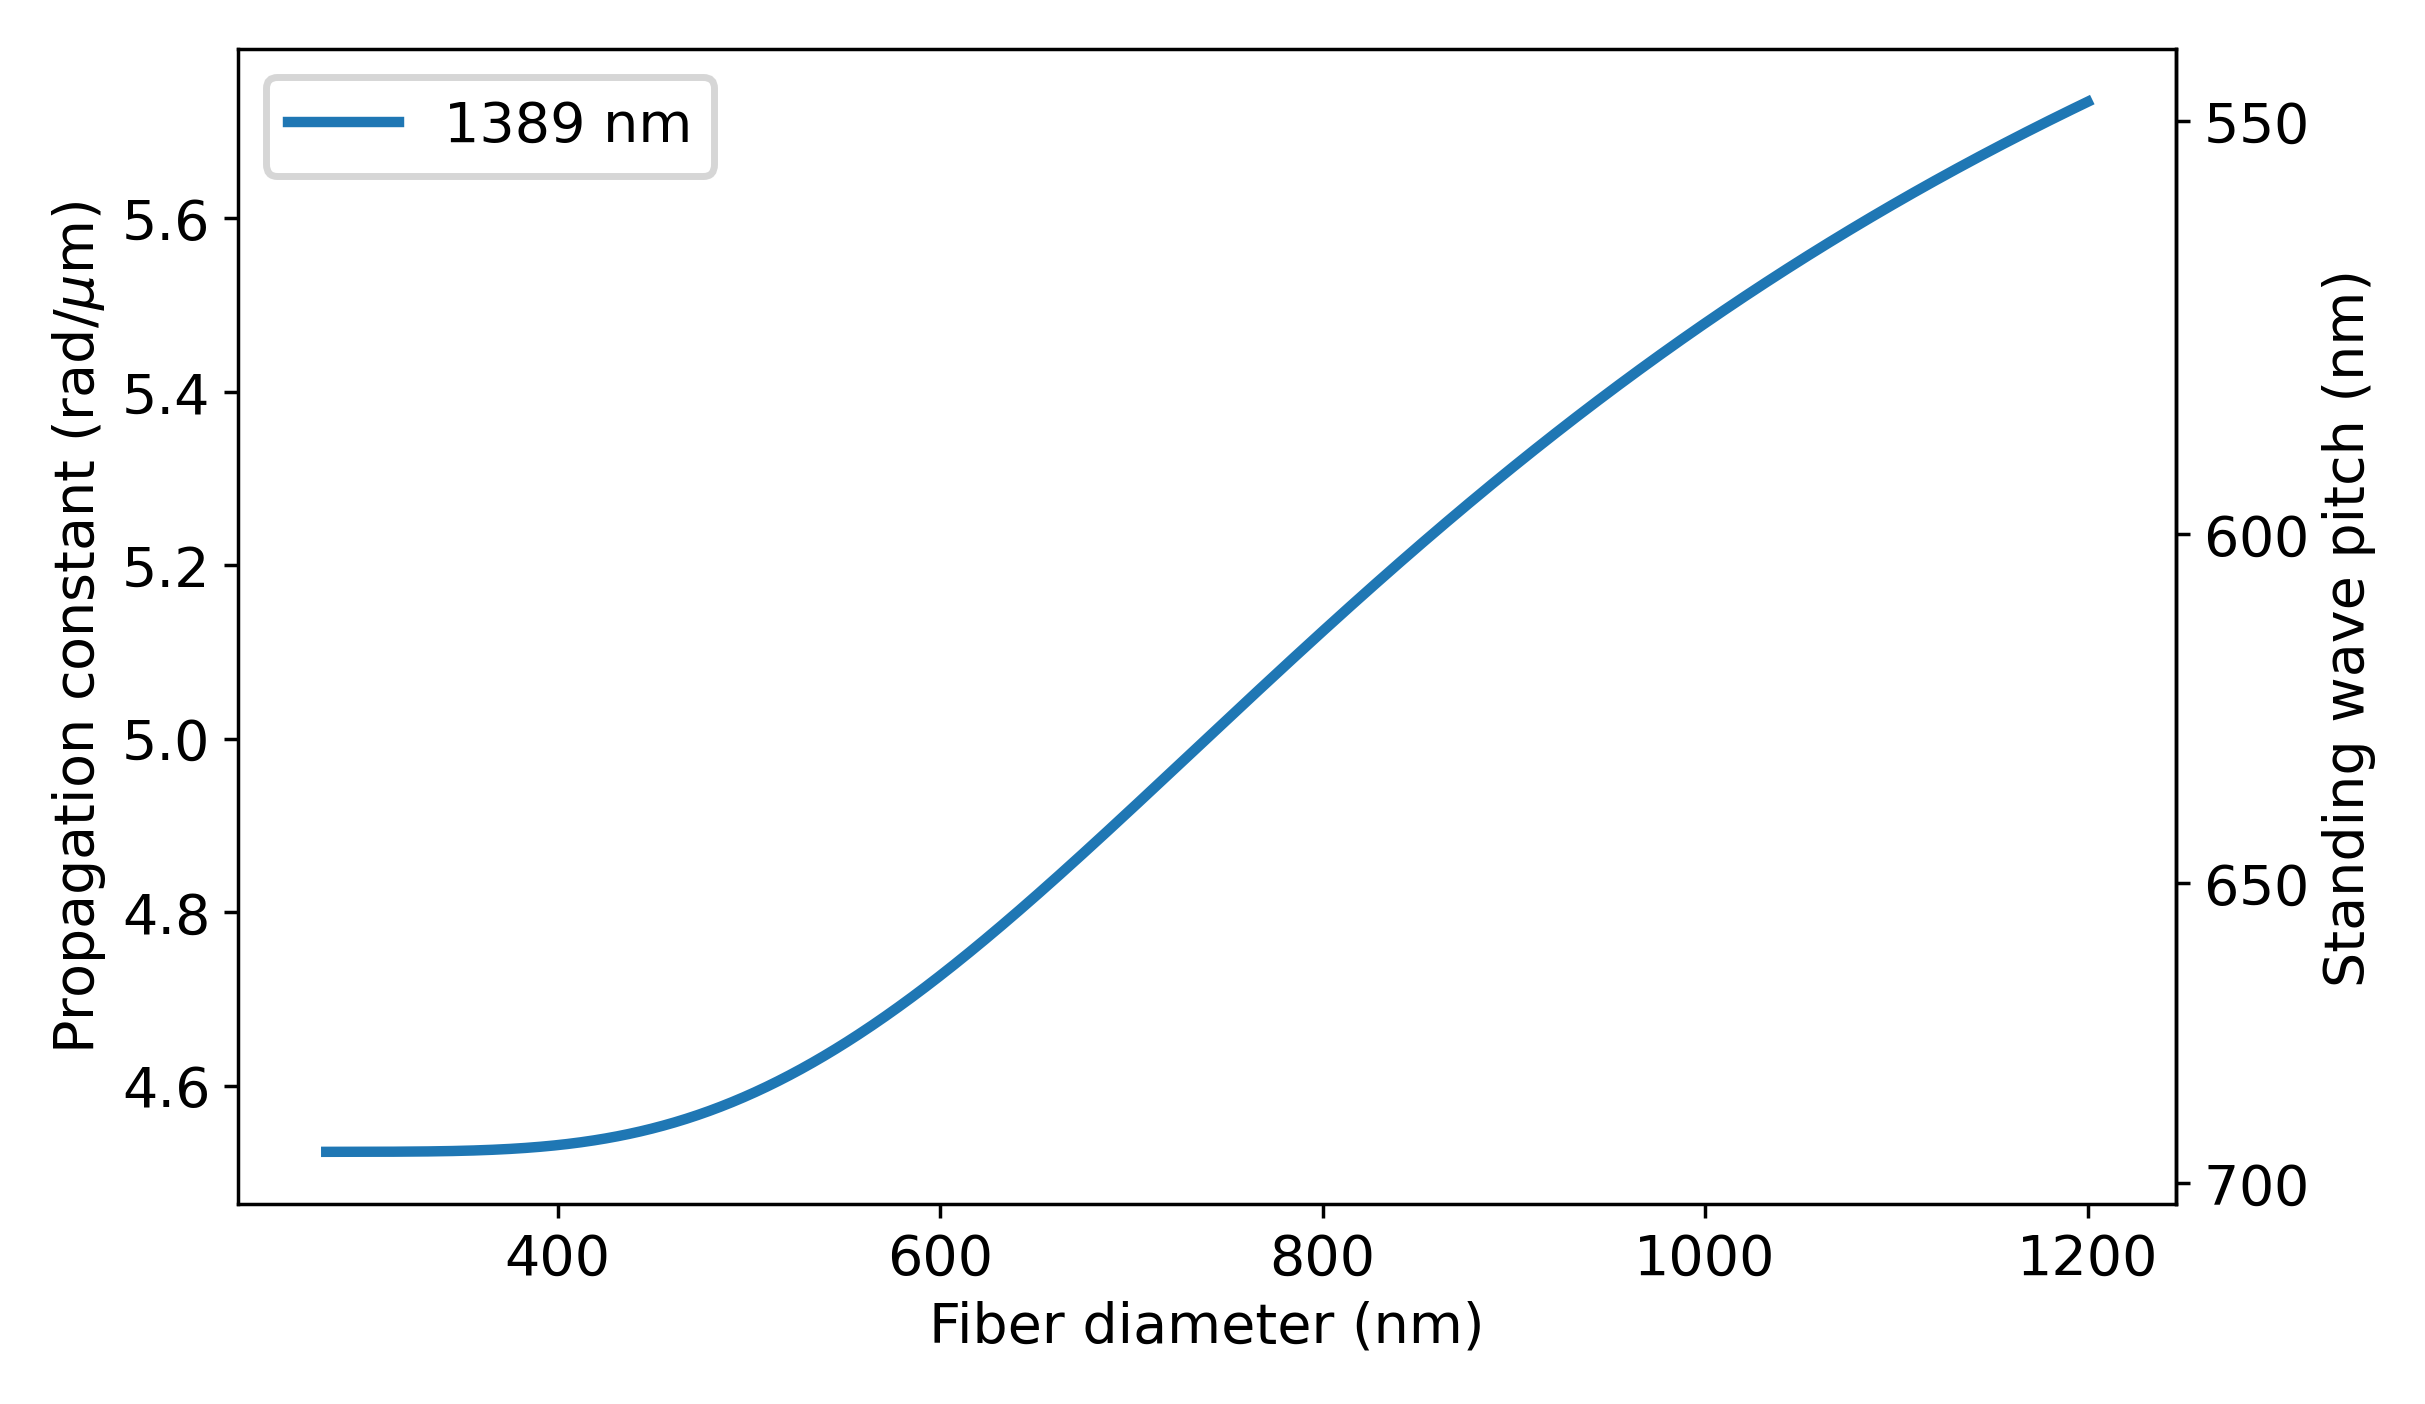

In [4]:
wavelengths = [1389]
diameters = np.linspace(200, 1200, 1000)

fig,ax = plt.subplots(figsize=(5,3))

for wl in wavelengths:
    betas = [beta(d*nm, wl*nm)*um for d in diameters]
    pitches = [pitch(d*nm, wl*nm)/nm for d in diameters]
    ax.plot(diameters, betas, label=str(wl)+' nm')

ax_right = ax.secondary_yaxis('right')
pitch_ticks = np.arange(400, 850, 50)
ax_right.set_yticks(np.pi/pitch_ticks *um/nm)
ax_right.set_yticklabels(['$'+str(p)+'$' for p in pitch_ticks])

ax.set_ylabel('Propagation constant (rad/$\mu$m)')
ax.set_xlabel('Fiber diameter (nm)')
ax_right.set_ylabel('Standing wave pitch (nm)')
ax.legend();

In [5]:
# Save the pitch and diameter
pitches = np.pi / np.array(betas, float)
# Remove NaNs and matching diameters
mask = np.isfinite(pitches)           # True where pitch is not NaN
pitches_clean = pitches[mask]
diameters_clean = diameters[mask]

from scipy.interpolate import interp1d

# Perform linear interpolation
interpolator = interp1d(pitches_clean, diameters_clean, kind='linear', fill_value='extrapolate')

# Example usage: interpolating a new set of pitches
new_pitches = np.linspace(pitches_clean.min(), pitches_clean.max(), 5000)
interpolated_diameters = interpolator(new_pitches)
interpolated_diameters = np.array(interpolated_diameters, float)*1e-9

np.savez('./pitches_and_diameters_1389.npz', pitches_1389=new_pitches, diameters_1389=interpolated_diameters)


In [6]:
data = np.load('./diameter_pitch_profile.npz')
pitch_values = data['pitch_values']
interpolated_dia_values = data['interpolated_dia_values']

print(interpolated_dia_values)

[6.95149430e-07 6.95130664e-07 6.95111898e-07 ... 4.54176906e-07
 4.54129514e-07 4.54082122e-07]


# Polarization measurement

In [7]:
def E(wavelength, r, phi, z, t):
    k0 = 2*np.pi/wavelength
    omega = 2*np.pi*c/wavelength
    n_fiber = n_silica(wavelength)
    b = beta(diameter, wavelength)
    a = diameter/2

    h11 = np.sqrt(k0**2 * n_fiber**2 -  b**2)
    q11 = np.sqrt(b**2 - k0**2 * n_air**2)
    s11 = (1/(h11*a)**2 + 1/(q11*a)**2) / (jvp(1, h11*a)/(h11*a*jv(1, h11*a)) + kvp(1, q11*a)/(q11*a*kv(1, q11*a)))

    Ex = A * b * jv(1, h11 * a) / (2 * q11 * kv(1, q11 * a)) * ((1 - s11) * kv(0, q11 * r) * np.cos(phi0) + (1 + s11) * kv(2, q11 * r) * np.cos(2 * phi - phi0)) * np.exp(1j * (omega * t - b * z))
    Ey = A * b * jv(1, h11 * a) / (2 * q11 * kv(1, q11 * a)) * ((1 - s11) * kv(0, q11 * r) * np.sin(phi0) + (1 + s11) * kv(2, q11 * r) * np.sin(2 * phi - phi0)) * np.exp(1j * (omega * t - b * z))
    Ez = 1j * A * jv(1, h11 * a) / kv(1, q11 * a) * kv(1, q11 * r) * np.cos(phi - phi0) * np.exp(1j * (omega * t - b * z))

    Esq = np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2

    return Ex,Ey,Ez,Esq
    

<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_26776\3552316512.py:23: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('$x$ ($\mu$m)')
C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_26776\3552316512.py:24: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$y$ ($\mu$m)');


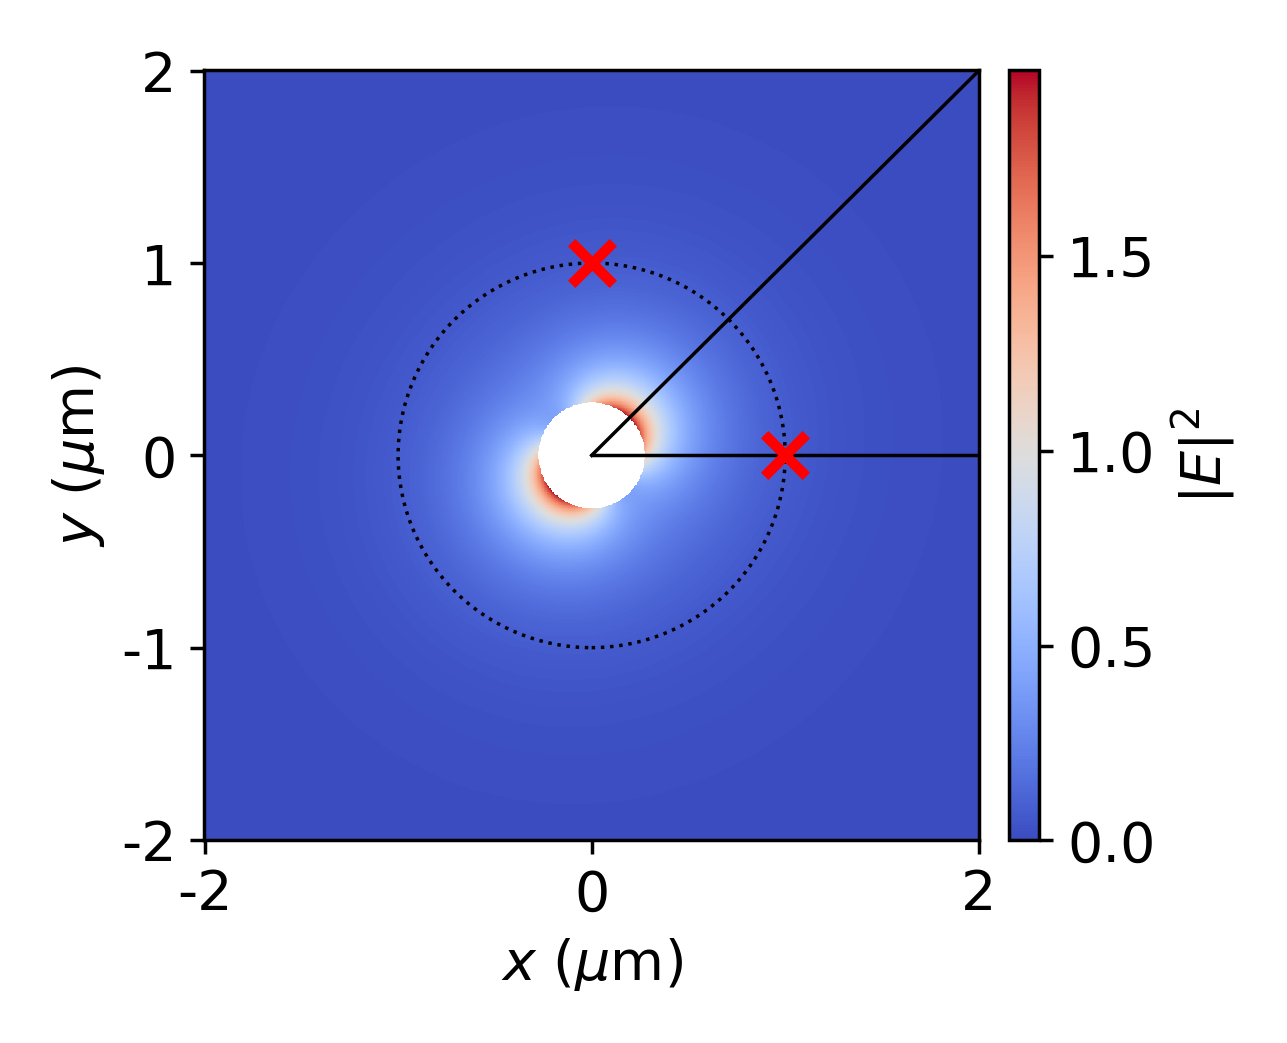

In [8]:
wavelength = 1389*nm
diameter = 550*nm
z = 0
phi0 = np.pi/4
A = 1

R_max = 2*um
num_points = 1000
x = np.linspace(-R_max, R_max, num_points)
y = np.linspace(-R_max, R_max, num_points)
X, Y = np.meshgrid(x, y)

R = np.sqrt(X**2 + Y**2)
PHI = np.arctan2(Y, X)

mask_outside = R >= diameter/2

Etot_sq = np.full(R.shape, np.nan)
Etot_sq[mask_outside] = E(wavelength, R[mask_outside], PHI[mask_outside], z, 0)[-1]

fig,ax = plt.subplots(figsize=(2, 2))
Eplot = ax.pcolormesh(X/um, Y/um, Etot_sq, shading='auto', cmap='coolwarm', vmin=0)
ax.set_xlabel('$x$ ($\mu$m)')
ax.set_ylabel('$y$ ($\mu$m)');

axpos = ax.get_position()
cbar_ax = fig.add_axes([0.93, axpos.y0, 0.03, axpos.height])
cbar = fig.colorbar(Eplot, cbar_ax)
cbar.set_label('$|E|^2$')


ax.axhline(y=0, xmin=0.5, xmax=1, ls='-', lw=0.5, c='k')
ax.plot([0,2], [0,2], ls='-', lw=0.5, c='k')
circ = patches.Circle(xy=(0, 0), radius=1, fc='None', ec='k', lw=0.5, ls=':')
ax.add_patch(circ)
ax.scatter([1,0], [0,1], marker='x', c='r', zorder=5)

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_26776\3629851955.py:14: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(rotations, Esq_ratio, label='$r=$ '+str(np.round(R/um,1))+' $\mu$m')
C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_26776\3629851955.py:16: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$\phi$ (degree)')
C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_26776\3629851955.py:17: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$A_\parallel / A_\perp$')


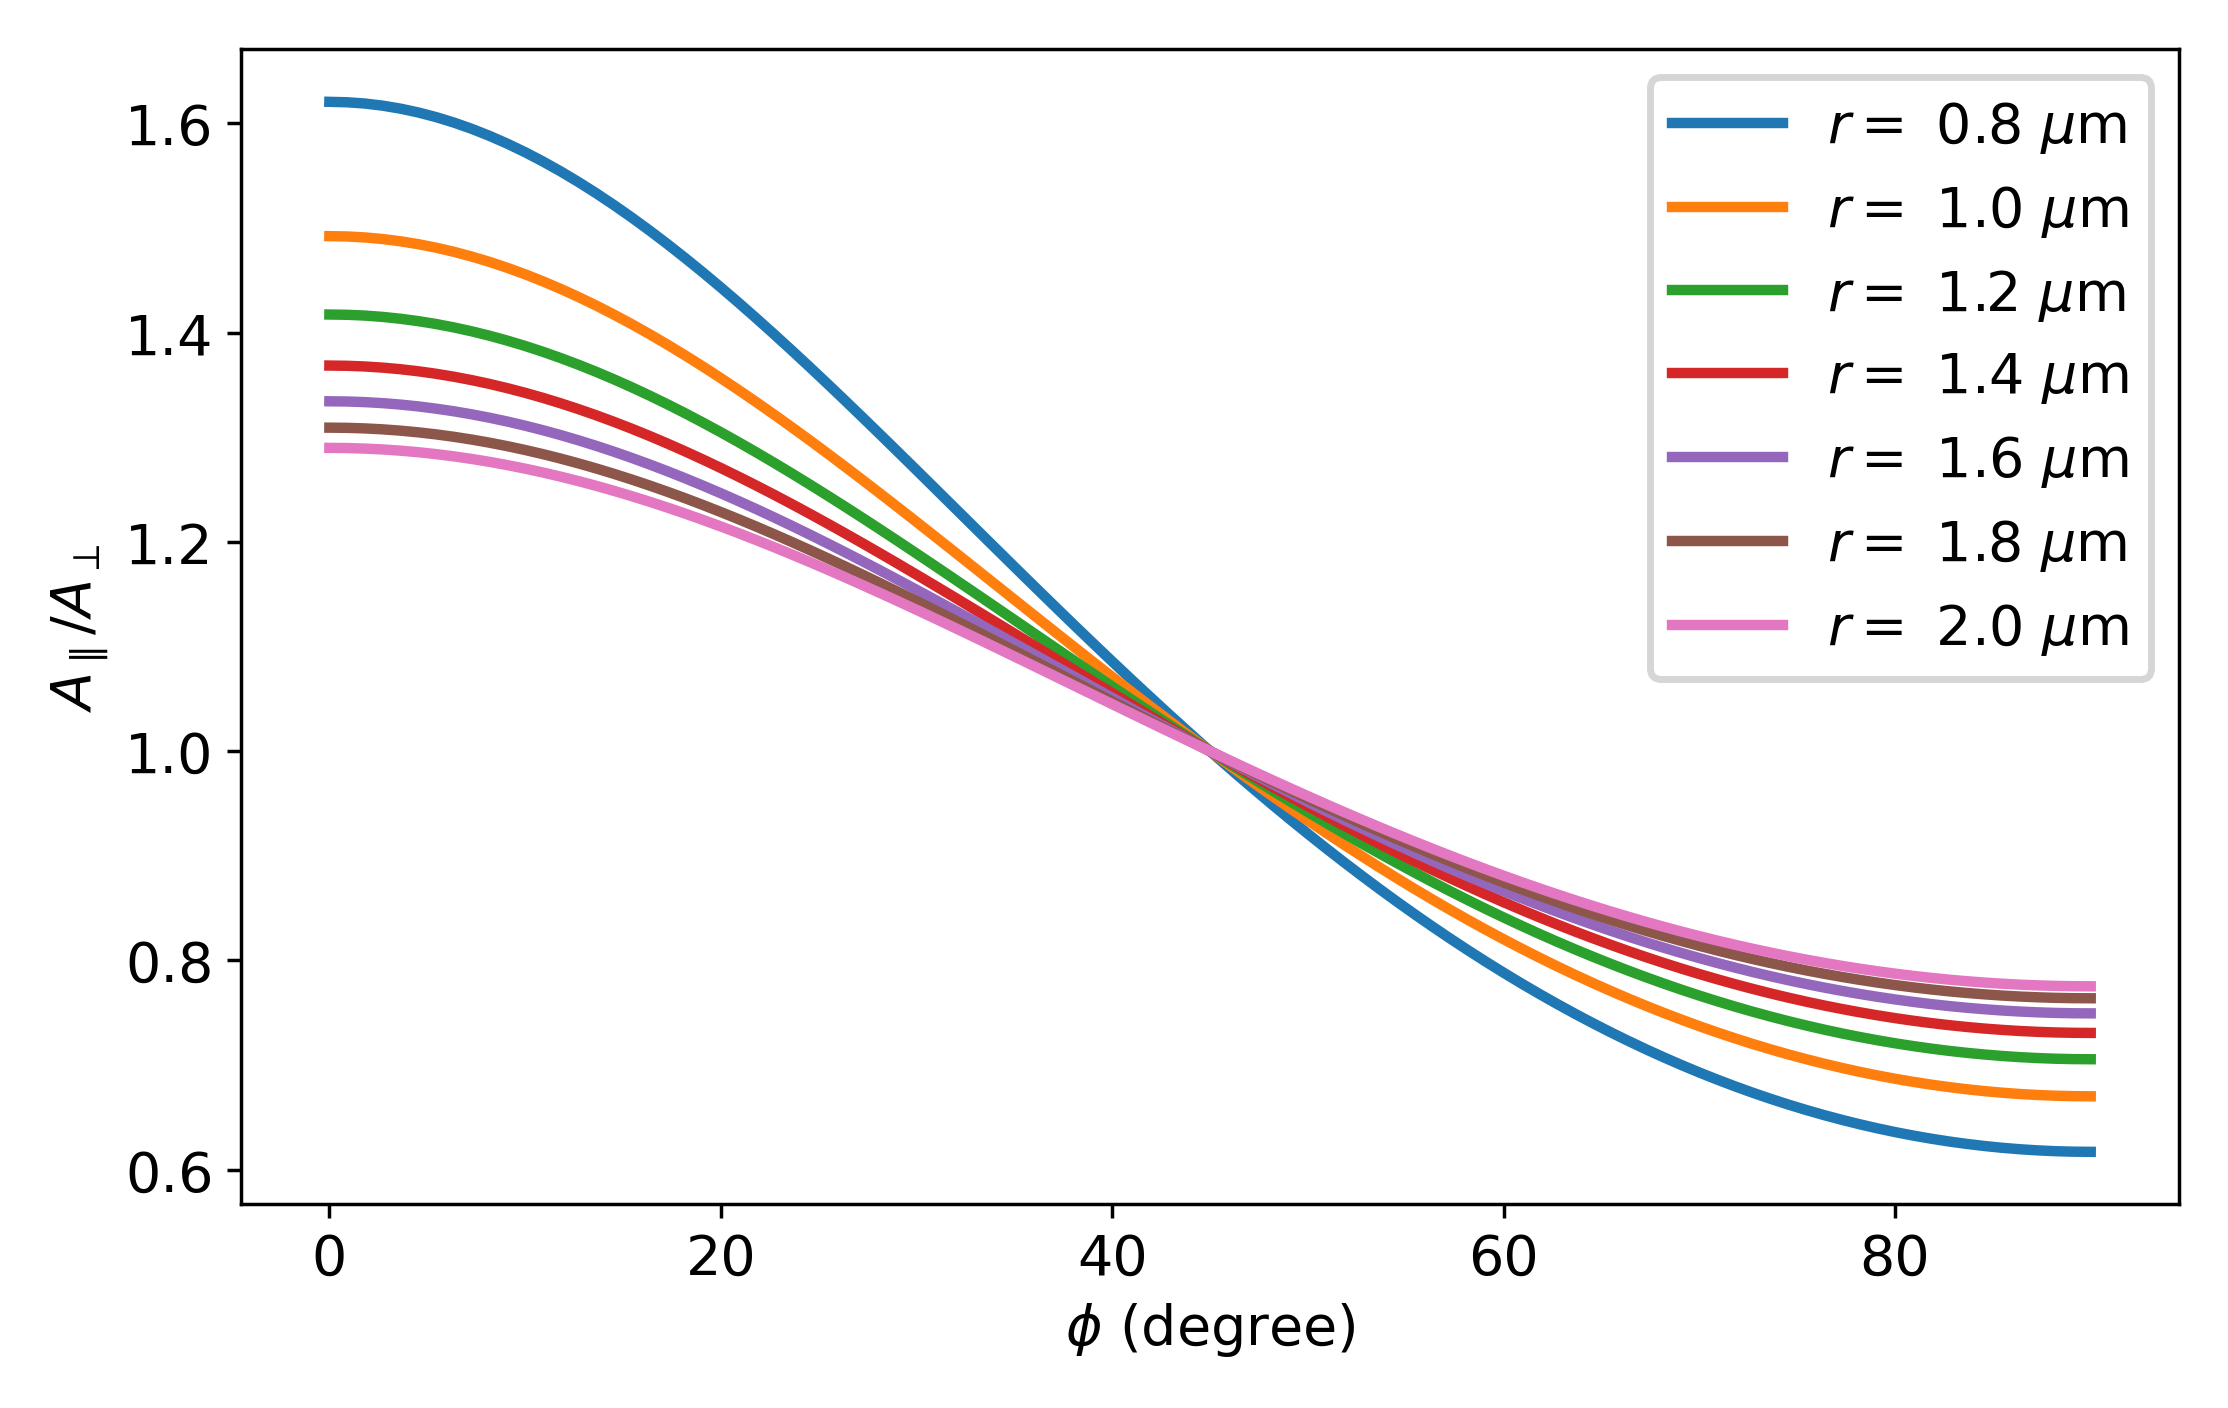

In [9]:
rotations = np.linspace(0, 90, 100)

fig,ax = plt.subplots(figsize=(5,3))

for R in np.arange(800*nm, 2.1*um, 200*nm):

    Esq_ratio = []
    for phi0 in rotations:
        phi0 *= np.pi/180
        E_h = E(wavelength, R, 0, z, 0)[-1]
        E_v = E(wavelength, R, np.pi/2, z, 0)[-1]
        Esq_ratio.append(E_h/E_v)

    ax.plot(rotations, Esq_ratio, label='$r=$ '+str(np.round(R/um,1))+' $\mu$m')

ax.set_xlabel('$\phi$ (degree)')
ax.set_ylabel('$A_\parallel / A_\perp$')
ax.legend();

<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_26776\3400214749.py:18: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$\phi$ (degree)')
C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_26776\3400214749.py:19: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$A_\parallel / A_\perp$')


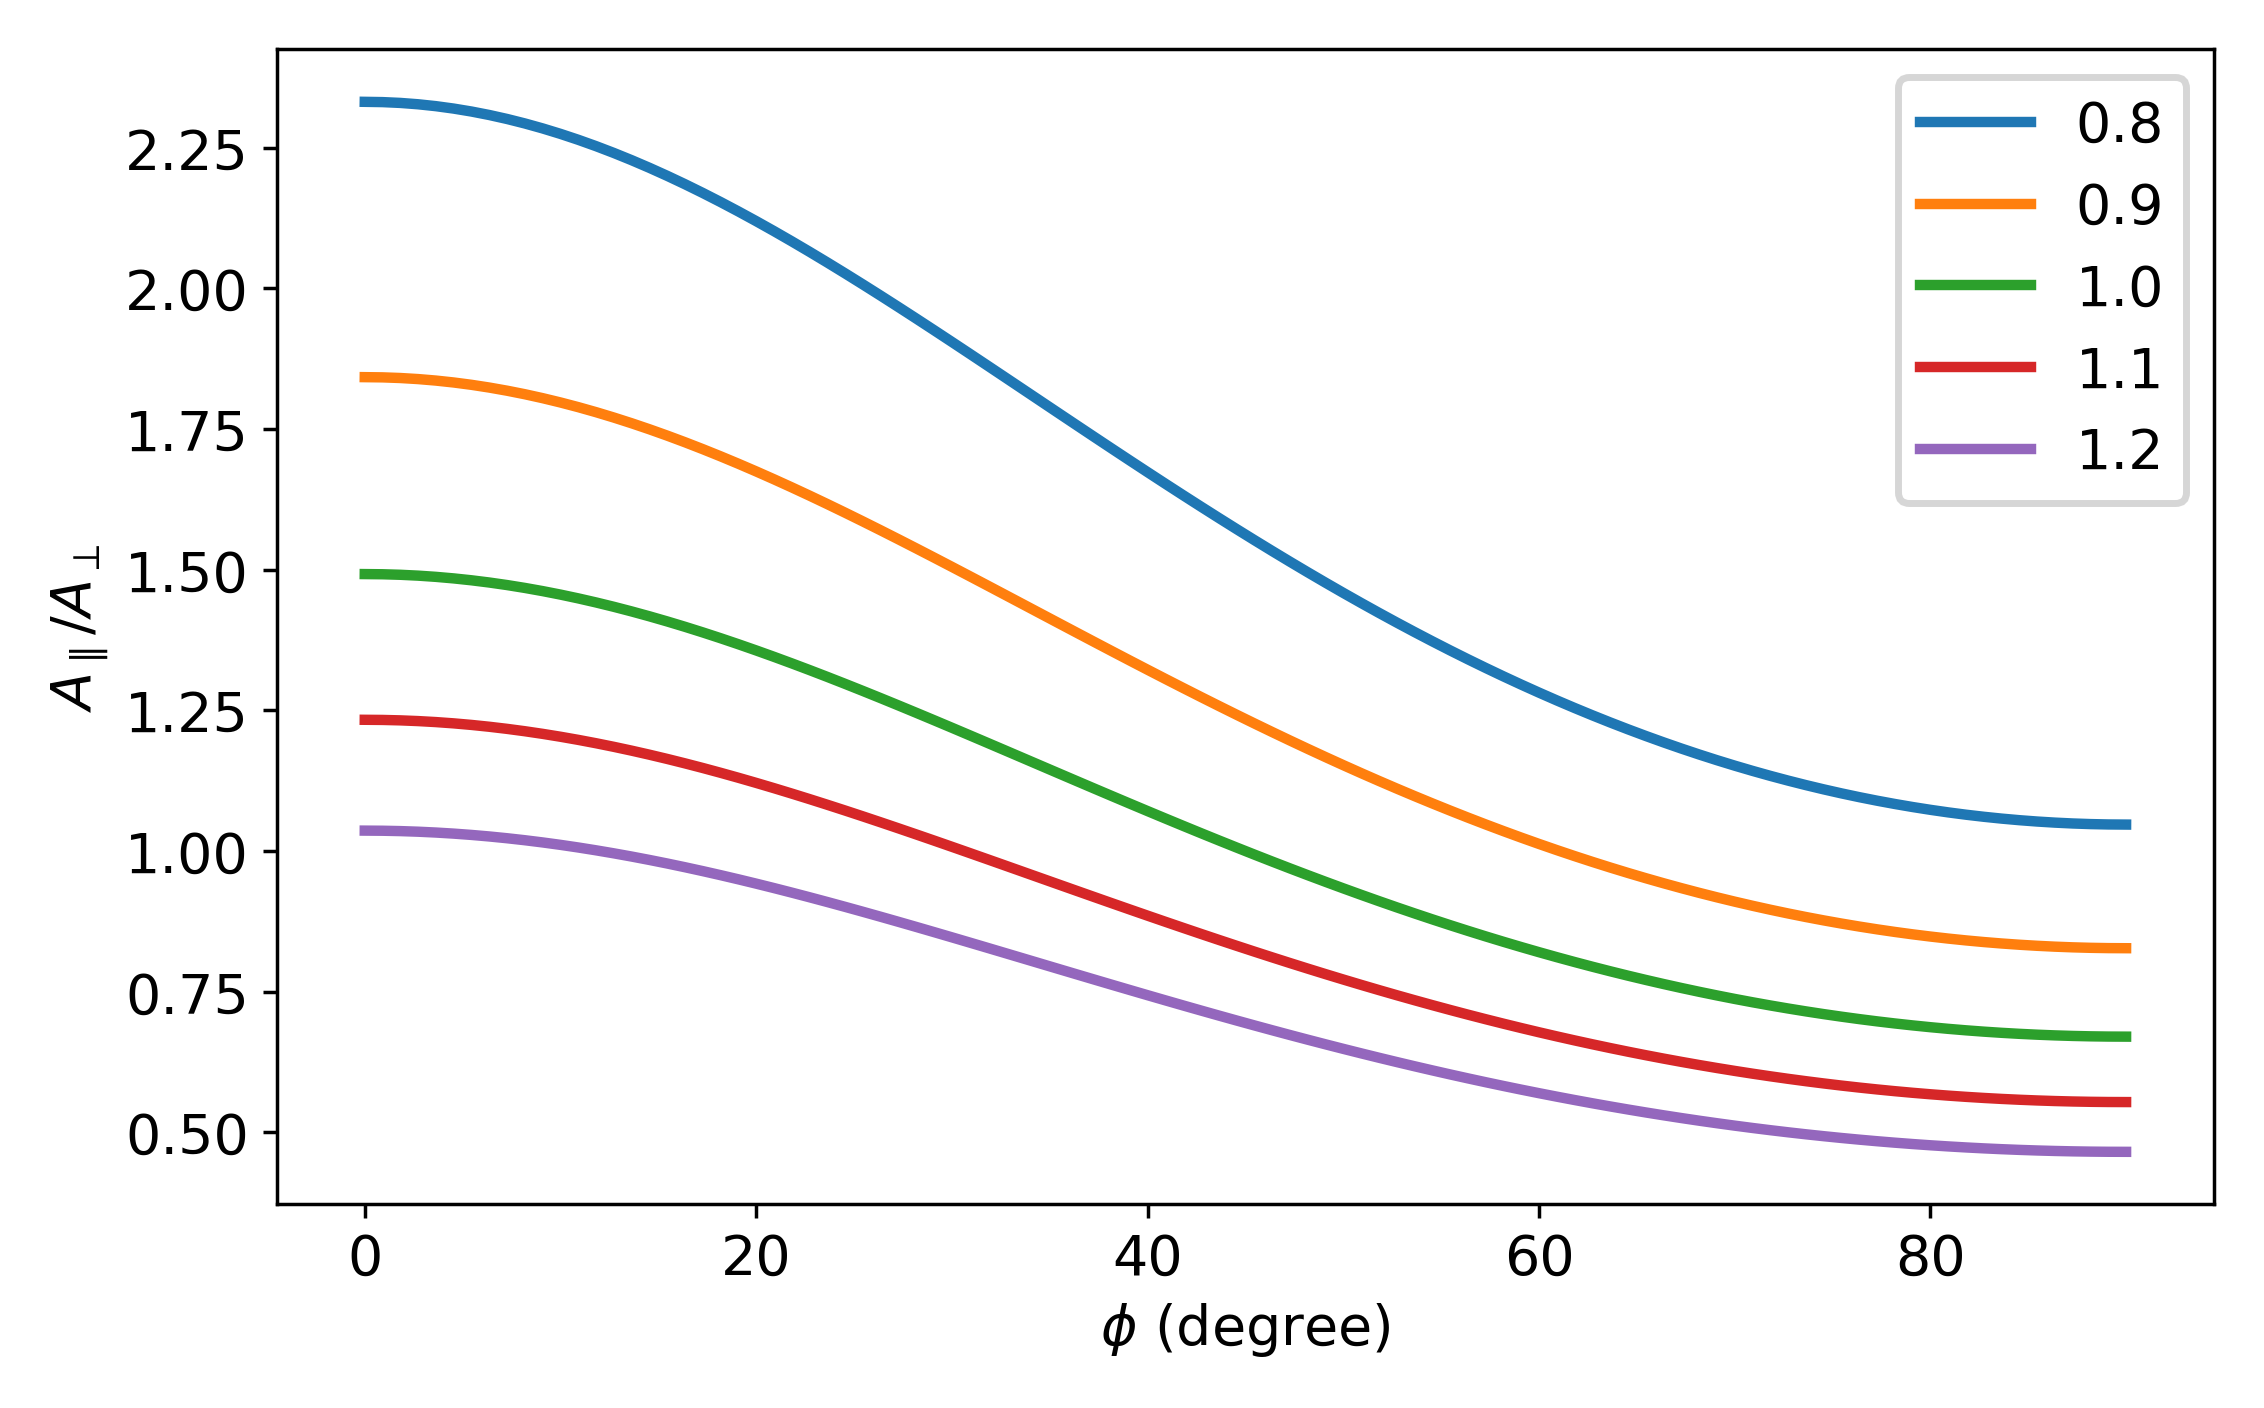

In [10]:
rotations = np.linspace(0, 90, 100)

fig,ax = plt.subplots(figsize=(5,3))
R = 1*um
for amp in np.arange(0.8, 1.3, 0.1):

    Esq_ratio = []
    for phi0 in rotations:
        phi0 *= np.pi/180
        A = 1
        E_h = E(wavelength, R, 0, z, 0)[-1]
        A = amp
        E_v = E(wavelength, R, np.pi/2, z, 0)[-1]
        Esq_ratio.append(E_h/E_v)

    ax.plot(rotations, Esq_ratio, label=amp)

ax.set_xlabel('$\phi$ (degree)')
ax.set_ylabel('$A_\parallel / A_\perp$')
ax.legend();

<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_26776\2233932282.py:23: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('$x$ ($\mu$m)')
C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_26776\2233932282.py:24: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$y$ ($\mu$m)');


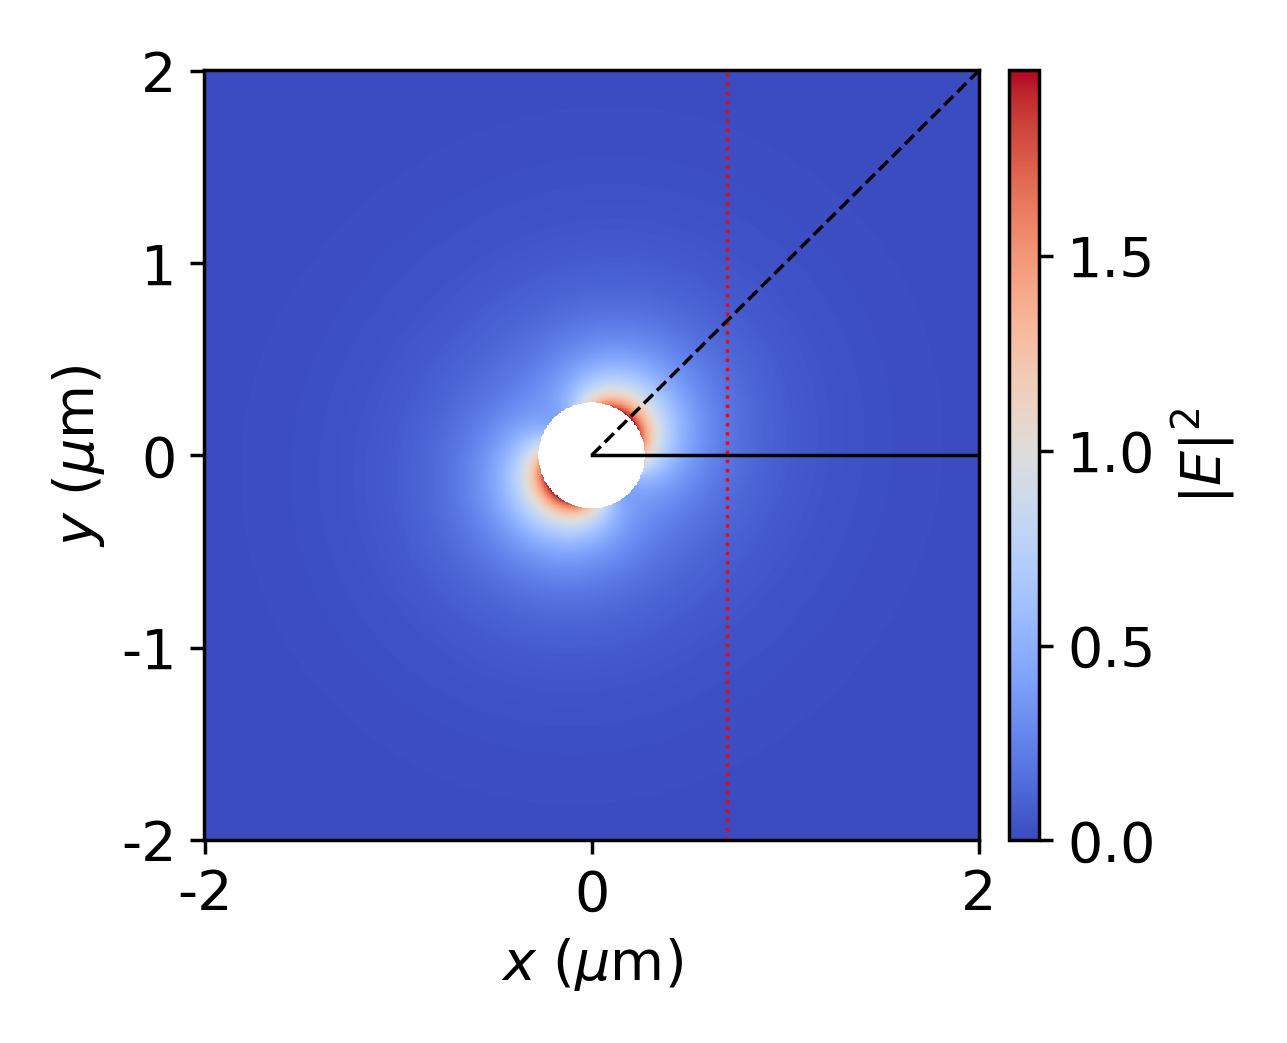

In [18]:
wavelength = 1389*nm
diameter = 550*nm
z = 0
phi0 = np.pi/4
A = 1

R_max = 2*um
num_points = 1000
x = np.linspace(-R_max, R_max, num_points)
y = np.linspace(-R_max, R_max, num_points)
X, Y = np.meshgrid(x, y)

R = np.sqrt(X**2 + Y**2)
PHI = np.arctan2(Y, X)

mask_outside = R >= diameter/2

Etot_sq = np.full(R.shape, np.nan)
Etot_sq[mask_outside] = E(wavelength, R[mask_outside], PHI[mask_outside], z, 0)[-1]

fig,ax = plt.subplots(figsize=(2, 2))
Eplot = ax.pcolormesh(X/um, Y/um, Etot_sq, shading='auto', cmap='coolwarm', vmin=0)
ax.set_xlabel('$x$ ($\mu$m)')
ax.set_ylabel('$y$ ($\mu$m)');

axpos = ax.get_position()
cbar_ax = fig.add_axes([0.93, axpos.y0, 0.03, axpos.height])
cbar = fig.colorbar(Eplot, cbar_ax)
cbar.set_label('$|E|^2$')

ax.axvline(0.7, ls=':', c='r', lw=0.5)
ax.axhline(y=0, xmin=0.5, xmax=1, ls='-', lw=0.5, c='k')
ax.plot([0,2], [0,2], ls='--', lw=0.5, c='k');

<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_26776\2306033529.py:23: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('$x$ ($\mu$m)')
C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_26776\2306033529.py:24: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$y$ ($\mu$m)');


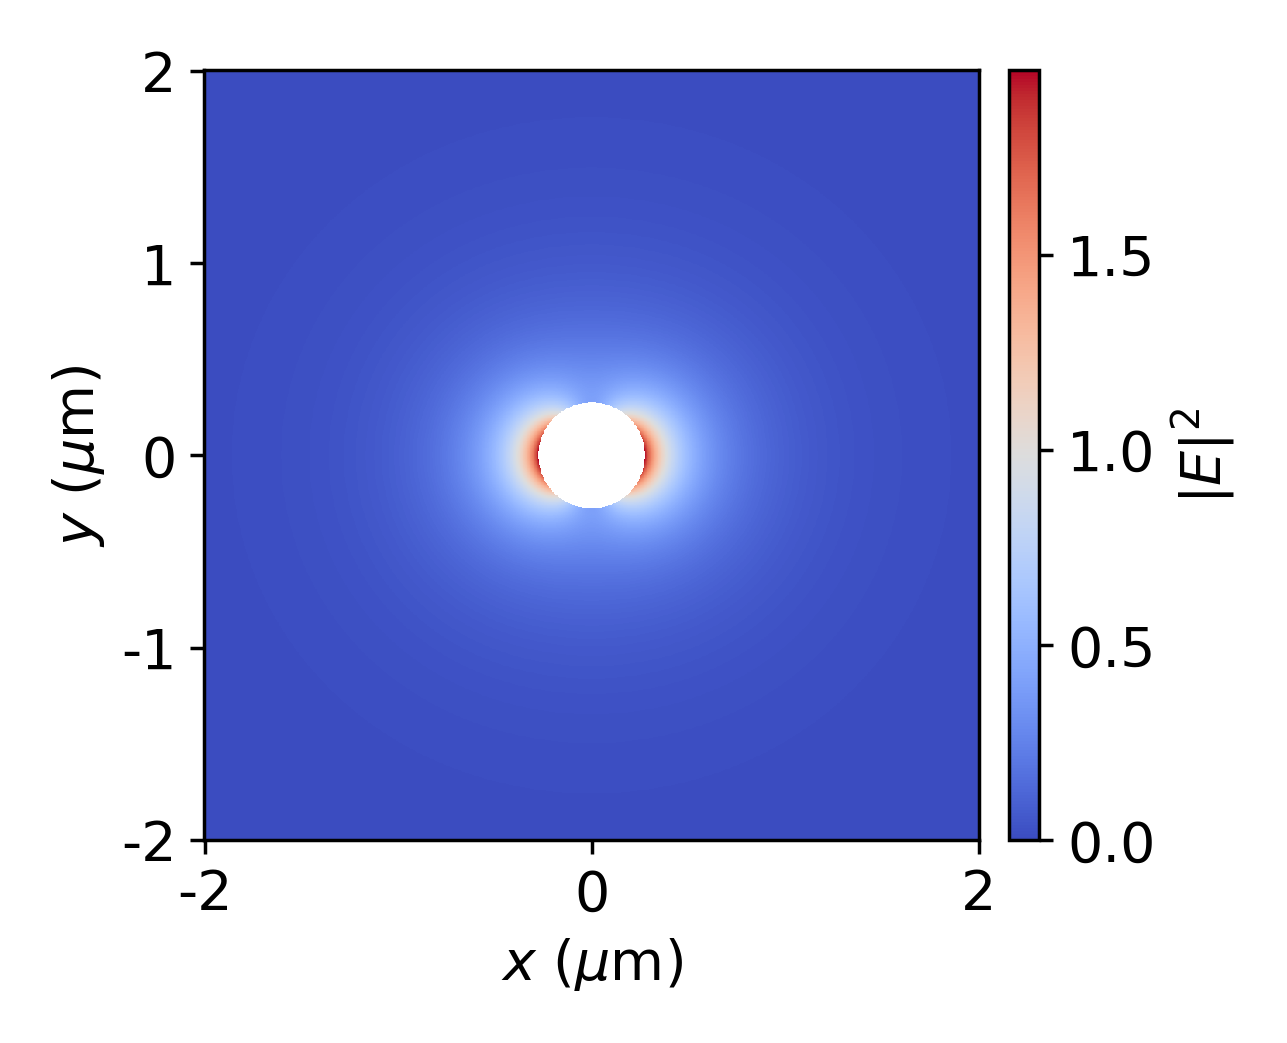

In [38]:
wavelength = 1389*nm
diameter = 550*nm
z = 0
phi0 = 0
A = 1

R_max = 2*um
num_points = 1000
x = np.linspace(-R_max, R_max, num_points)
y = np.linspace(-R_max, R_max, num_points)
X, Y = np.meshgrid(x, y)

R = np.sqrt(X**2 + Y**2)
PHI = np.arctan2(Y, X)

mask_outside = R >= diameter/2

Etot_sq = np.full(R.shape, np.nan)
Etot_sq[mask_outside] = E(wavelength, R[mask_outside], PHI[mask_outside], z, 0)[-1]

fig,ax = plt.subplots(figsize=(2, 2))
Eplot = ax.pcolormesh(X/um, Y/um, Etot_sq, shading='auto', cmap='coolwarm', vmin=0)
ax.set_xlabel('$x$ ($\mu$m)')
ax.set_ylabel('$y$ ($\mu$m)');

axpos = ax.get_position()
cbar_ax = fig.add_axes([0.93, axpos.y0, 0.03, axpos.height])
cbar = fig.colorbar(Eplot, cbar_ax)
cbar.set_label('$|E|^2$')

# ax.axvline(0.7, ls=':', c='r', lw=0.5)
# ax.axhline(y=0, xmin=0.5, xmax=1, ls='-', lw=0.5, c='k')
# ax.plot([0,2], [0,2], ls='--', lw=0.5, c='k');

<>:28: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_26776\3486690054.py:28: SyntaxWarning: invalid escape sequence '\c'
  ax[idx].set_title(r'$\varphi_0='+str(phi_ofs)+'^\circ$')
C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_26776\3486690054.py:37: SyntaxWarning: invalid escape sequence '\m'
  ax[-3].set_xlabel('$y$ ($\mu$m)')


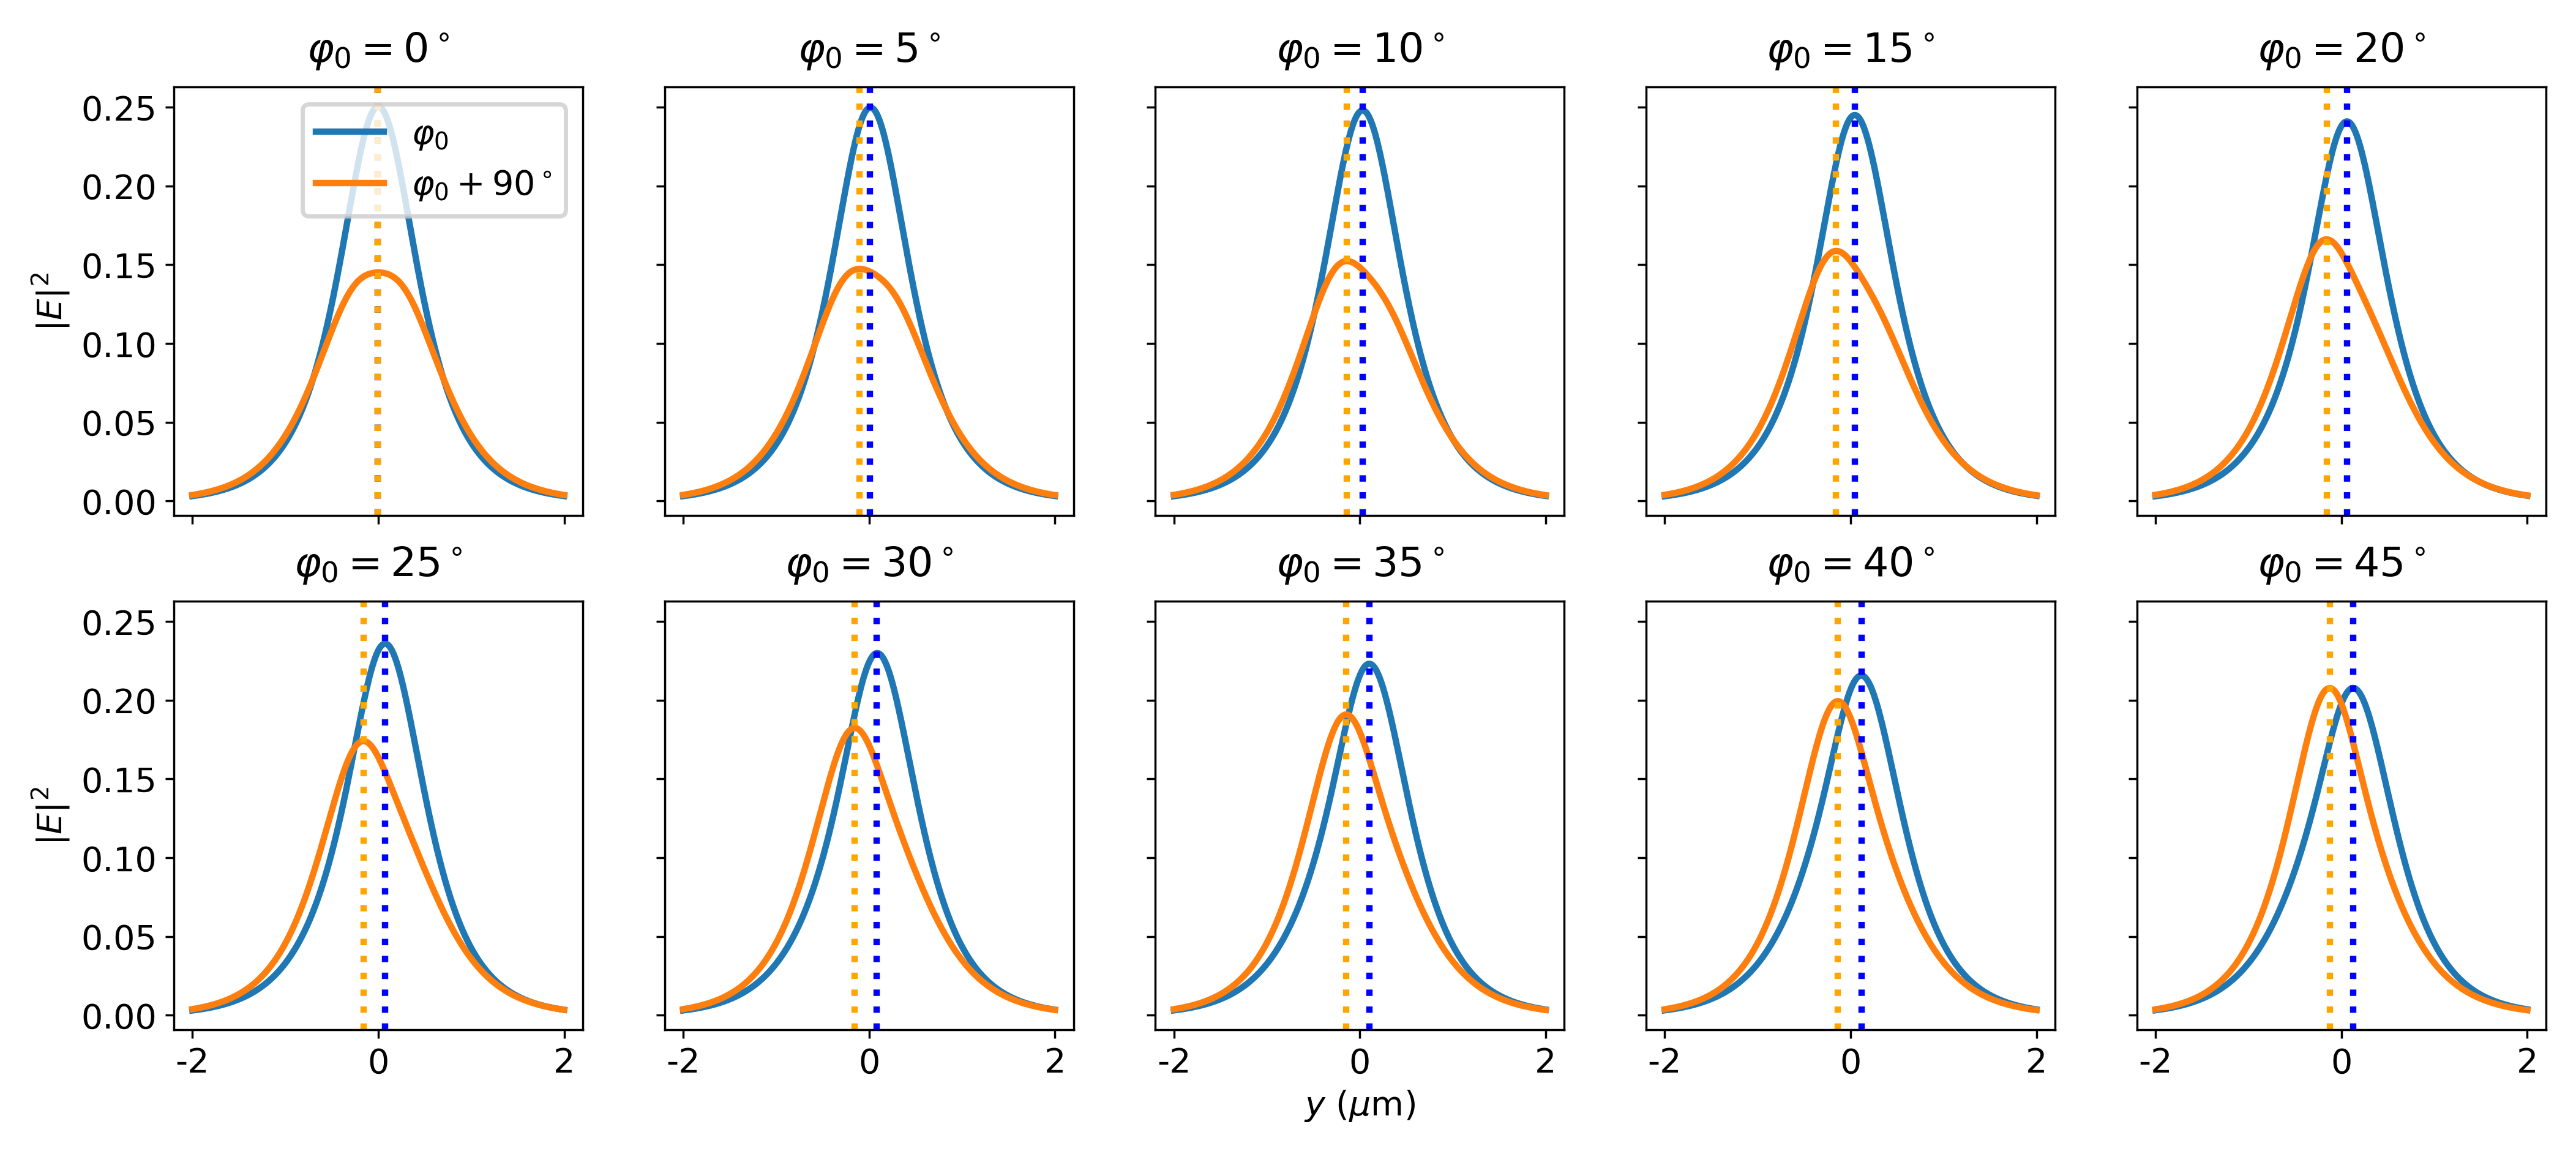

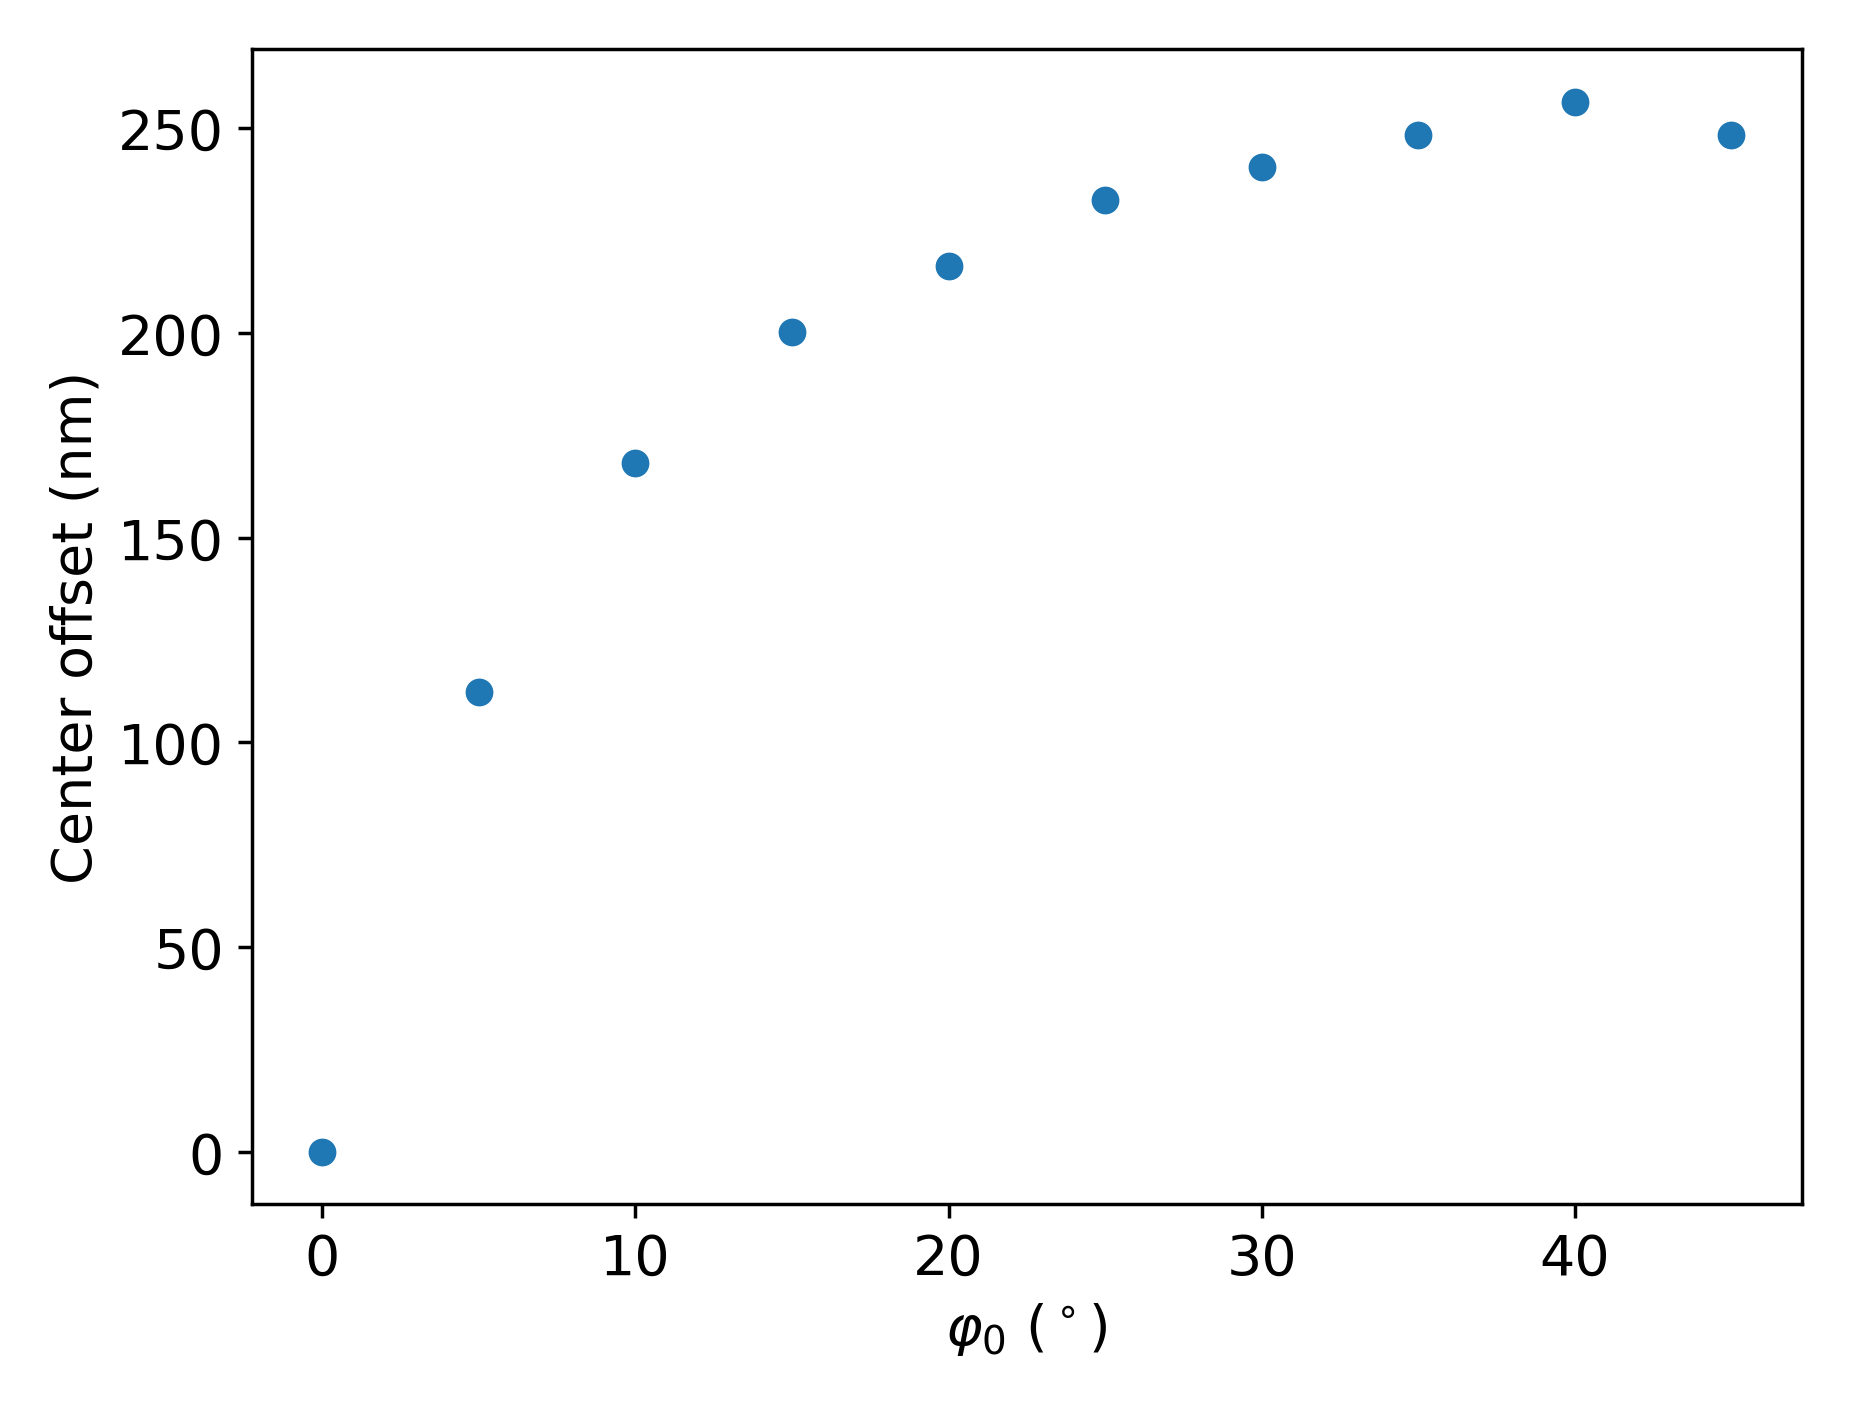

In [45]:
wavelength = 1389*nm
diameter = 550*nm
z = 0
A = 1

x = 700*nm
ys = np.linspace(-2*um, 2*um, 500)

fig,ax = plt.subplots(2, 5, figsize=(10, 4), sharex=True, sharey=True)
ax = ax.ravel()

dif = []
phi_offsets = np.arange(0, 46, 5)
for idx,phi_ofs in enumerate(phi_offsets):
    phi0 = phi_ofs*np.pi/180
    Es0,Es1 = [],[]
    for y in ys:
        r = np.sqrt(x**2 + y**2)
        phi = np.arctan(y/x)
        Es0.append(E(wavelength, r, phi, z, 0)[-1])
        phi0 += np.pi/2
        Es1.append(E(wavelength, r, phi, z, 0)[-1])
        phi0 -= np.pi/2

    ax[idx].plot(ys/um, Es0, label=r'$\varphi_0$')
    ax[idx].plot(ys/um, Es1, label=r'$\varphi_0+90^\circ$')

    ax[idx].set_title(r'$\varphi_0='+str(phi_ofs)+'^\circ$')
    ax[0].legend()

    max0 = ys[np.argmax(Es0)]
    max1 = ys[np.argmax(Es1)]
    ax[idx].axvline(max0/um, ls=':', c='b')
    ax[idx].axvline(max1/um, ls=':', c='orange')
    dif.append(max0/nm - max1/nm)

ax[-3].set_xlabel('$y$ ($\mu$m)')
ax[0].set_ylabel('$|E|^2$')
ax[5].set_ylabel('$|E|^2$')

fig,ax = plt.subplots(figsize=(4,3))
ax.plot(phi_offsets, dif, '.')
ax.set_xlabel(r'$\varphi_0$ $(^\circ)$')
ax.set_ylabel('Center offset (nm)');

<>:28: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_26776\923645901.py:28: SyntaxWarning: invalid escape sequence '\c'
  ax[idx].set_title(r'$\varphi_0='+str(phi_ofs)+'^\circ$')
C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_26776\923645901.py:37: SyntaxWarning: invalid escape sequence '\m'
  ax[-3].set_xlabel('$y$ ($\mu$m)')


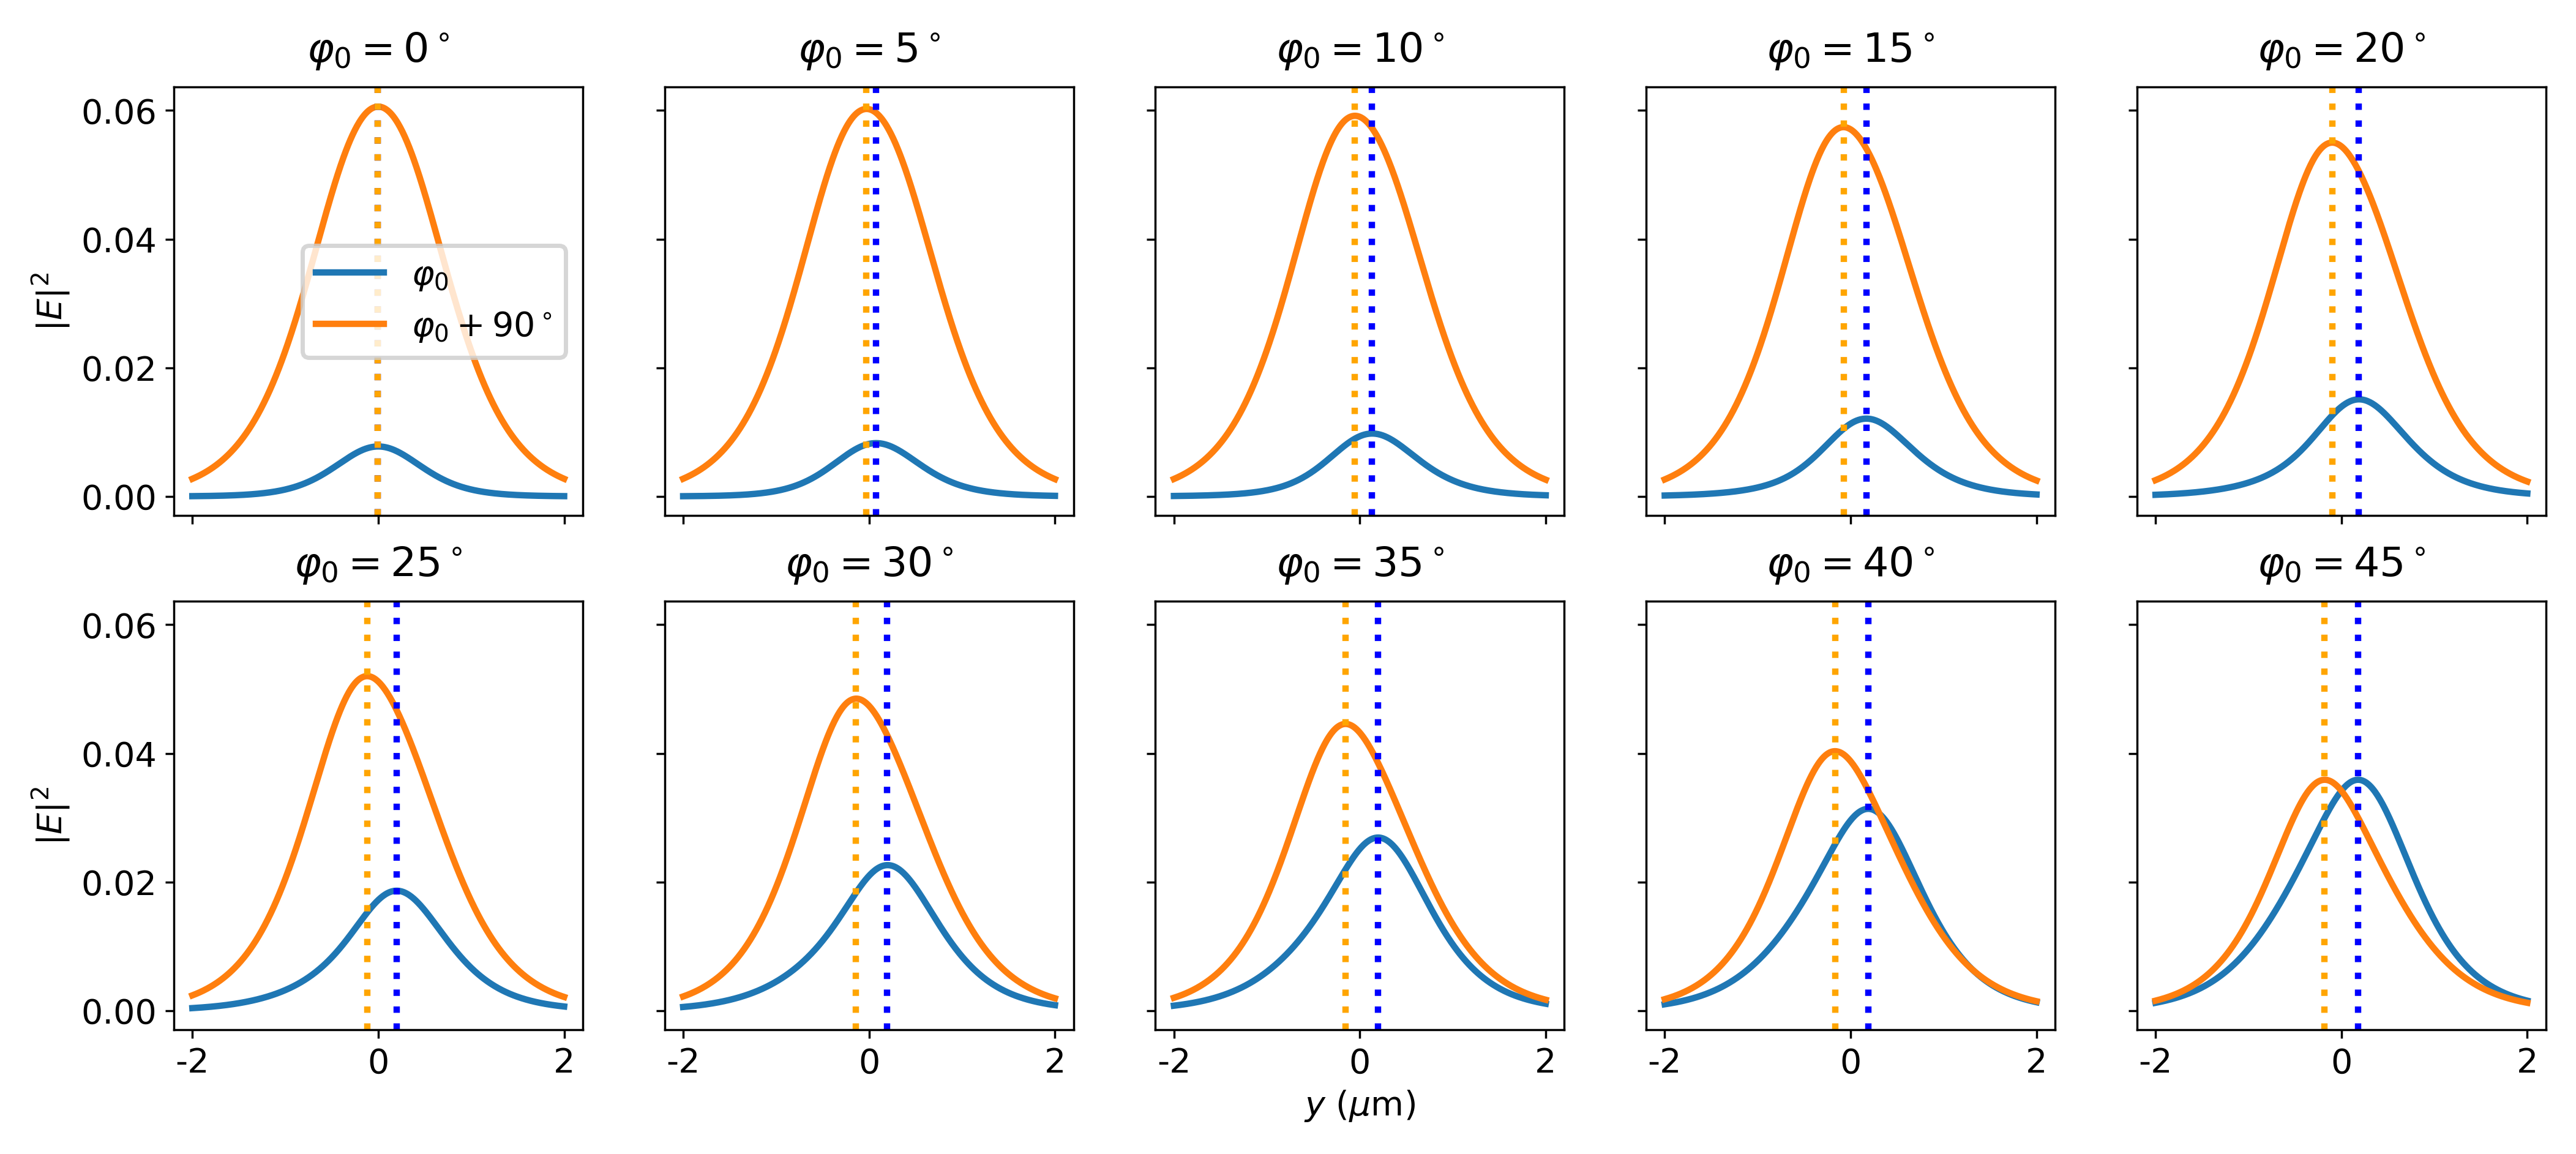

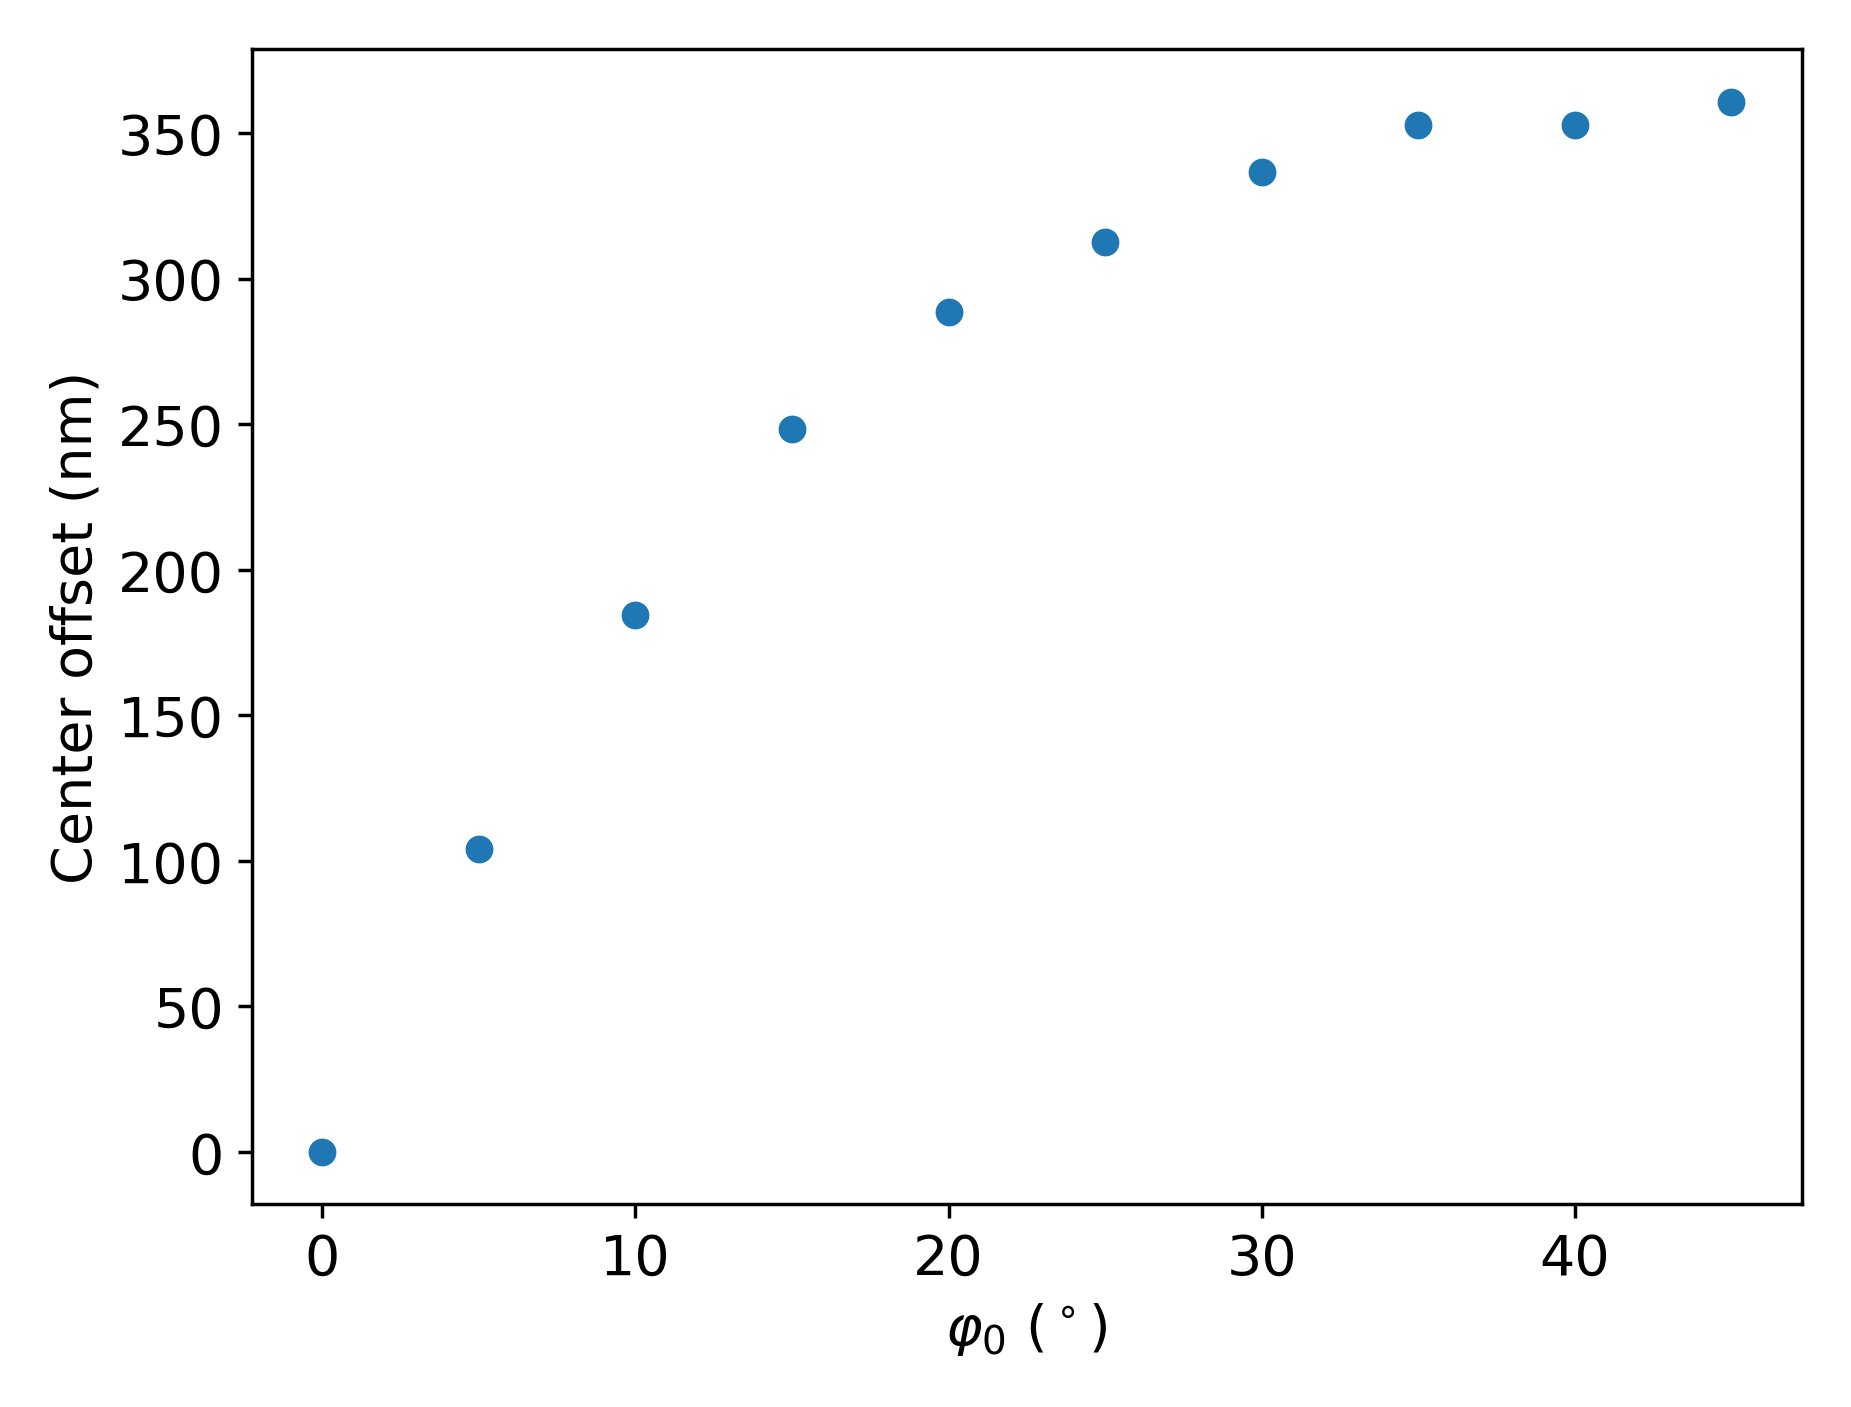

In [ ]:
wavelength = 1389*nm
diameter = 550*nm
z = 0
A = 1

x = 700*nm
ys = np.linspace(-2*um, 2*um, 500)

fig,ax = plt.subplots(2, 5, figsize=(10, 4), sharex=True, sharey=True)
ax = ax.ravel()

dif = []
phi_offsets = np.arange(0, 46, 5)
for idx,phi_ofs in enumerate(phi_offsets):
    phi0 = phi_ofs*np.pi/180
    Es0,Es1 = [],[]
    for y in ys:
        r = np.sqrt(x**2 + y**2)
        phi = np.arctan(y/x)
        Es0.append(abs(E(wavelength, r, phi, z, 0)[1])**2 + abs(E(wavelength, r, phi, z, 0)[2])**2)
        phi0 += np.pi/2
        Es1.append(abs(E(wavelength, r, phi, z, 0)[1])**2 + abs(E(wavelength, r, phi, z, 0)[2])**2)
        phi0 -= np.pi/2

    ax[idx].plot(ys/um, Es0, label=r'$\varphi_0$')
    ax[idx].plot(ys/um, Es1, label=r'$\varphi_0+90^\circ$')

    ax[idx].set_title(r'$\varphi_0='+str(phi_ofs)+'^\circ$')
    ax[0].legend()

    max0 = ys[np.argmax(Es0)]
    max1 = ys[np.argmax(Es1)]
    ax[idx].axvline(max0/um, ls=':', c='b')
    ax[idx].axvline(max1/um, ls=':', c='orange')
    dif.append(max0/nm - max1/nm)

ax[-3].set_xlabel('$y$ ($\mu$m)')
ax[0].set_ylabel('$|E|^2$')
ax[5].set_ylabel('$|E|^2$')

fig,ax = plt.subplots(figsize=(4,3))
ax.plot(phi_offsets, dif, '.')
ax.set_xlabel(r'$\varphi_0$ $(^\circ)$')
ax.set_ylabel('Center offset (nm)');

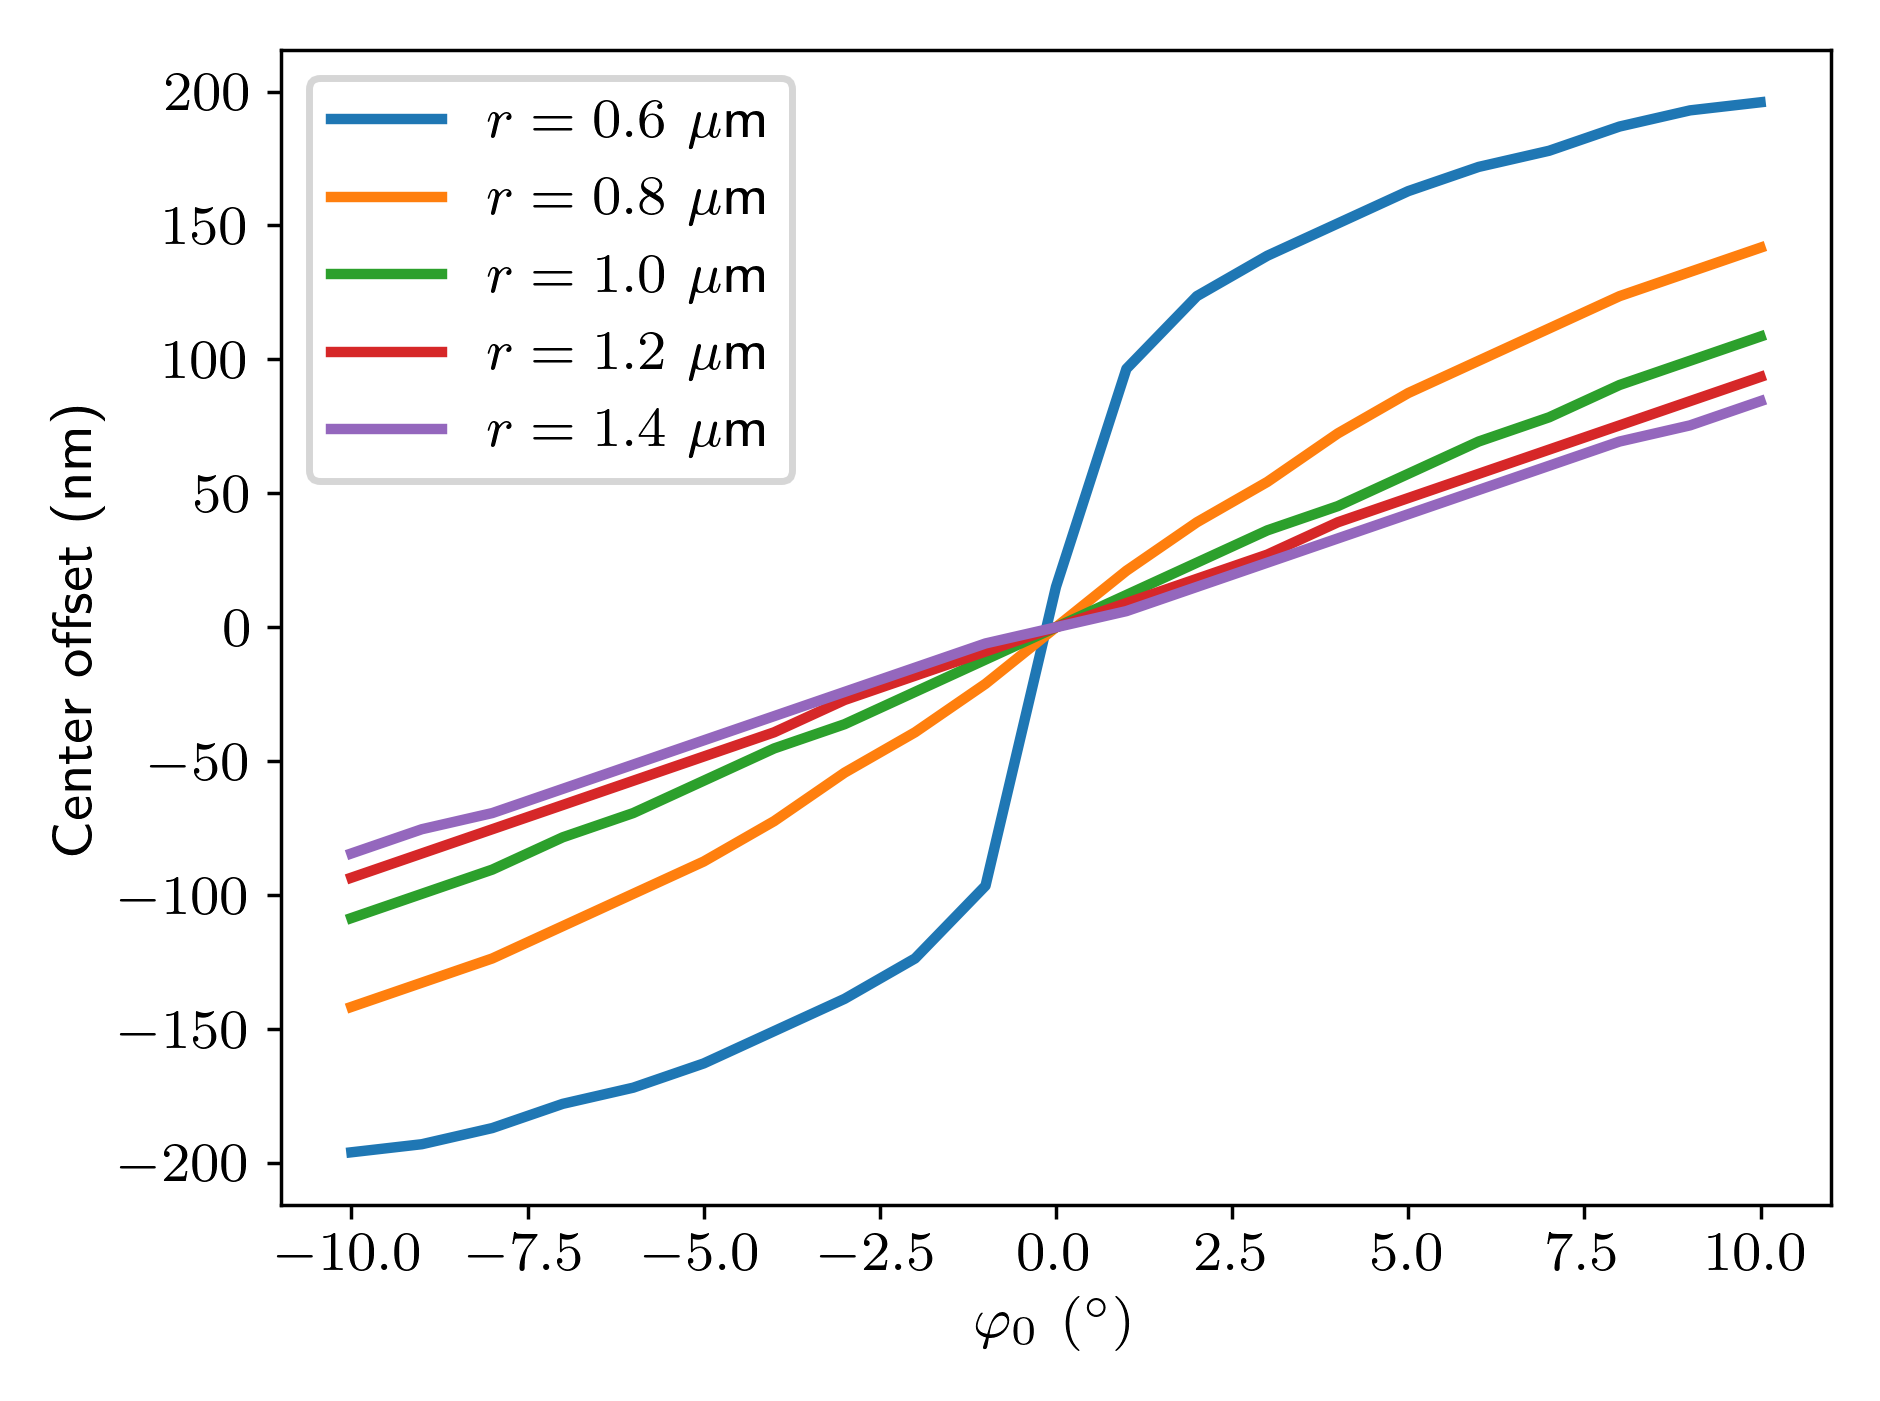

In [11]:
wavelength = 1389*nm
diameter = 550*nm
z = 0
A = 1

xs = np.arange(600*nm, 1.5*um, 200*nm)
ys = np.linspace(-300*nm, 300*nm, 200)
phi_offsets = np.arange(-10, 11, 1)

fig,ax = plt.subplots(figsize=(4,3))

for x in xs:
    dif = []
    for idx,phi_ofs in enumerate(phi_offsets):
        phi0 = phi_ofs*np.pi/180
        Es0,Es1 = [],[]
        for y in ys:
            r = np.sqrt(x**2 + y**2)
            phi = np.arctan(y/x)
            Es0.append(E(wavelength, r, phi, z, 0)[-1])
            phi0 += np.pi/2
            Es1.append(E(wavelength, r, phi, z, 0)[-1])
            phi0 -= np.pi/2

        max0 = ys[np.argmax(Es0)]
        max1 = ys[np.argmax(Es1)]
        dif.append(max0/nm - max1/nm)

    ax.plot(phi_offsets, dif, label='$r='+str(np.round(x/um,1))+'~\mu$m')
ax.set_xlabel(r'$\varphi_0$ $(^\circ)$')
ax.set_ylabel('Center offset (nm)')
ax.legend();

## Dual wavelength measurement

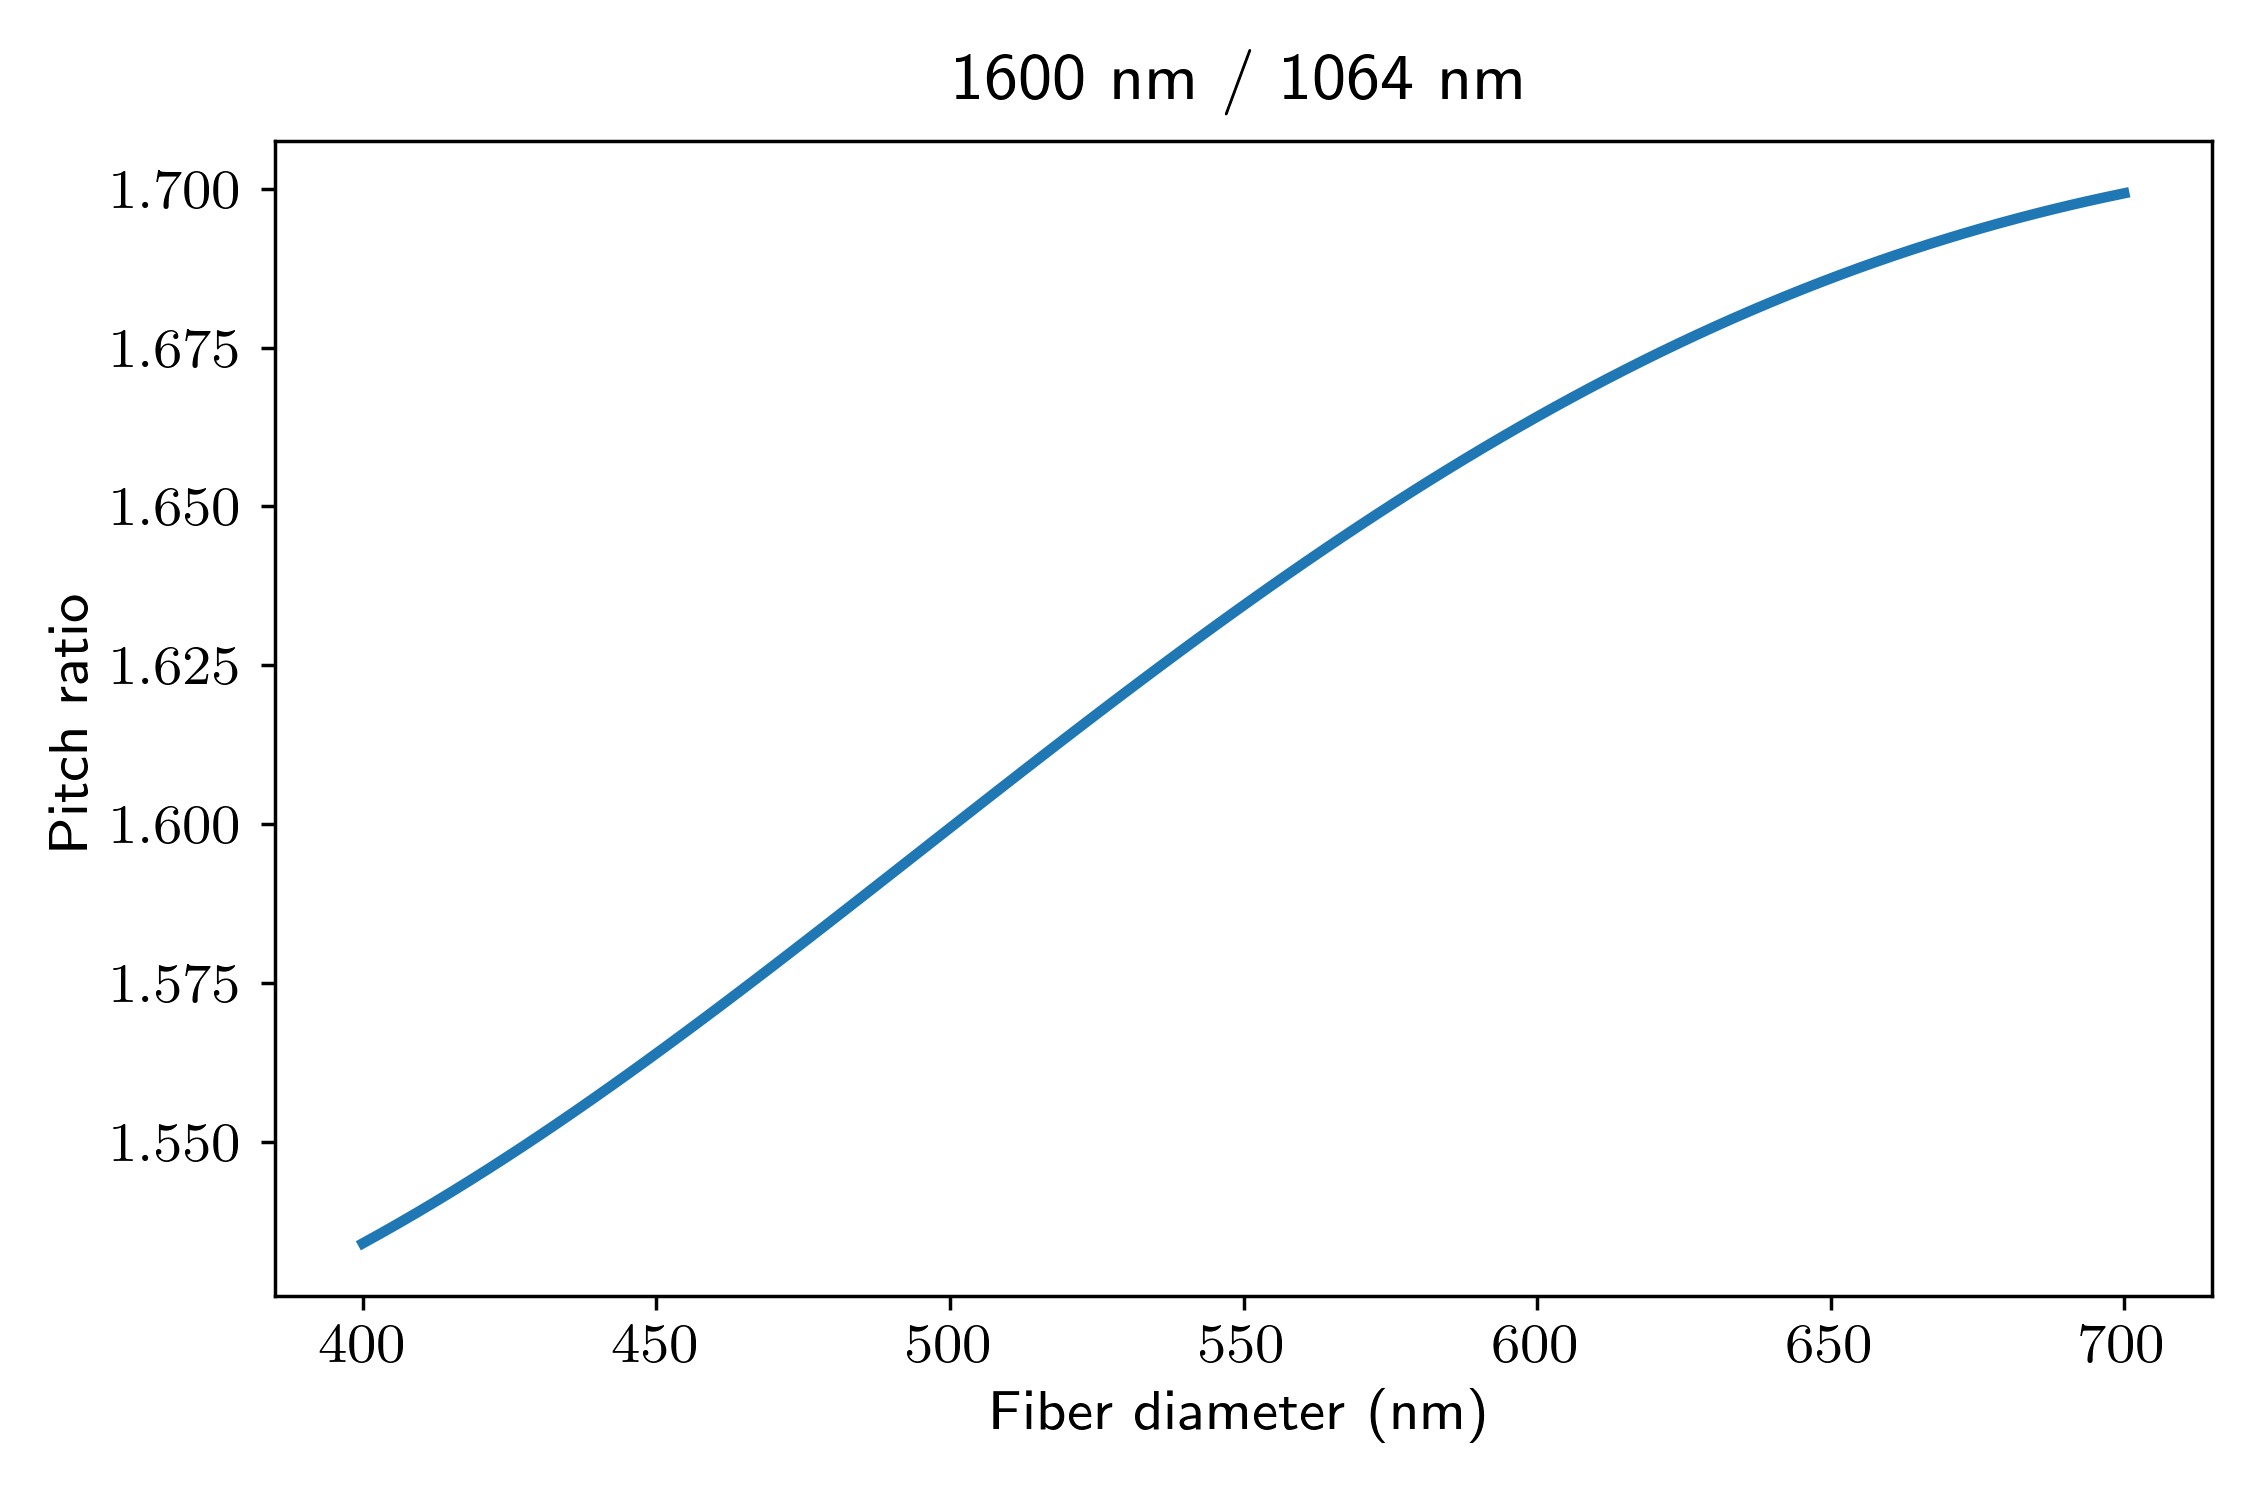

In [34]:
wavelength1 = 1600
wavelength2 = 1064
diameters = np.linspace(400, 700, 100)

pitch_ratio = [pitch(d*nm, wavelength1*nm)/pitch(d*nm, wavelength2*nm) for d in diameters]

fig,ax = plt.subplots(figsize=(5,3))
ax.plot(diameters, pitch_ratio)

ax.set_ylabel('Pitch ratio')
ax.set_xlabel('Fiber diameter (nm)')
ax.set_title(str(wavelength1)+' nm / '+str(wavelength2)+' nm');